# Batch Evaluation Results Analysis

This notebook analyzes the results from the batch evaluation of joint anomaly scores, focusing on:

1. **Performance by threshold scale** - Mean recall and FAR/hour before and after clustering
2. **Responder vs Non-responder analysis** - Separate analysis for datasets with seizures
3. **Clustering strategy analysis** - Most used clustering strategies across thresholds
4. **Clustering effectiveness** - Impact of clustering on anomaly reduction and performance

## Data Source
- Feather file: `evaluation_results.feather` from batch evaluation
- Contains results across multiple threshold scales (0.5 to 1.45 in 0.05 increments)
- Includes both basic evaluation metrics and clustering results

In [20]:
# Challenge Score Calculation
# Score = Sensitivity(%) - 0.4 * FA/h
# We will calculate this for both before and after clustering and take the mean over thresholds

def calculate_challenge_score(recall_percent, fa_per_hour):
    """
    Calculate the challenge score: Sensitivity(%) - 0.4 * FA/h
    
    Parameters:
    recall_percent: Sensitivity/Recall in percentage (0-100)
    fa_per_hour: False Alarms per hour
    
    Returns:
    Challenge score
    """
    return recall_percent - 0.4 * fa_per_hour

def add_challenge_scores(df):
    """
    Add challenge score columns to the dataframe for before and after clustering
    """
    df_copy = df.copy()
    
    # Calculate challenge score for before clustering (pre-clustering)
    if 'event_recall' in df_copy.columns and 'false_alarm_rate_per_hour' in df_copy.columns:
        # Convert recall to percentage (assuming it's in 0-1 range)
        recall_percent_pre = df_copy['event_recall'] * 100
        df_copy['challenge_score_pre'] = calculate_challenge_score(
            recall_percent_pre, 
            df_copy['false_alarm_rate_per_hour']
        )
    
    # Calculate challenge score for after clustering (post-clustering)
    if 'cluster_event_recall' in df_copy.columns and 'cluster_event_far_per_hour' in df_copy.columns:
        # Convert recall to percentage (assuming it's in 0-1 range)
        recall_percent_post = df_copy['cluster_event_recall'] * 100
        df_copy['challenge_score_post'] = calculate_challenge_score(
            recall_percent_post, 
            df_copy['cluster_event_far_per_hour']
        )
    
    return df_copy

def get_mean_challenge_scores(df):
    """
    Calculate mean challenge scores across all thresholds for deterministic results
    """
    results = {}
    
    # Mean challenge score before clustering
    if 'challenge_score_pre' in df.columns:
        # Group by dataset and calculate mean across thresholds
        mean_scores_pre = df.groupby('dataset_id')['challenge_score_pre'].mean()
        results['mean_challenge_score_pre'] = mean_scores_pre.mean()
        results['std_challenge_score_pre'] = mean_scores_pre.std()
        results['datasets_with_pre_scores'] = len(mean_scores_pre)
    
    # Mean challenge score after clustering
    if 'challenge_score_post' in df.columns:
        # Only consider datasets that have clustering results
        df_with_clustering = df.dropna(subset=['challenge_score_post'])
        if len(df_with_clustering) > 0:
            mean_scores_post = df_with_clustering.groupby('dataset_id')['challenge_score_post'].mean()
            results['mean_challenge_score_post'] = mean_scores_post.mean()
            results['std_challenge_score_post'] = mean_scores_post.std()
            results['datasets_with_post_scores'] = len(mean_scores_post)
            
            # Calculate improvement due to clustering
            # Only for datasets that have both pre and post scores
            common_datasets = set(df.groupby('dataset_id')['challenge_score_pre'].count().index) & \
                            set(mean_scores_post.index)
            if common_datasets:
                pre_scores_common = df[df['dataset_id'].isin(common_datasets)].groupby('dataset_id')['challenge_score_pre'].mean()
                post_scores_common = mean_scores_post[list(common_datasets)]
                improvement = post_scores_common.mean() - pre_scores_common.mean()
                results['challenge_score_improvement'] = improvement
                results['datasets_with_both_scores'] = len(common_datasets)
    
    return results

print("Challenge score calculation functions defined!")
print("Formula: Score = Sensitivity(%) - 0.4 * FA/h")
print("Functions available:")
print("- calculate_challenge_score(recall_percent, fa_per_hour)")
print("- add_challenge_scores(df)")
print("- get_mean_challenge_scores(df)")

Challenge score calculation functions defined!
Formula: Score = Sensitivity(%) - 0.4 * FA/h
Functions available:
- calculate_challenge_score(recall_percent, fa_per_hour)
- add_challenge_scores(df)
- get_mean_challenge_scores(df)


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the feather file with batch evaluation results
feather_path = "results/final/no-window/train/batch_results/evaluation_results.feather" # "results/final/window/test/batch_results/evaluation_results.feather"

try:
    df = pd.read_feather(feather_path)
    print(f"✓ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['dataset_id'].min()} to {df['dataset_id'].max()}")
    print(f"Threshold range: {df['threshold_scale'].min()} to {df['threshold_scale'].max()}")
    print(f"Unique datasets: {df['dataset_id'].nunique()}")
    print(f"Unique threshold scales: {df['threshold_scale'].nunique()}")
except FileNotFoundError:
    print(f"❌ Feather file not found at: {feather_path}")
    print("Available files in current directory:")
    for f in Path(".").glob("*.feather"):
        print(f"  {f}")
    print("\nAvailable batch_results directories:")
    for d in Path(".").glob("**/batch_results"):
        print(f"  {d}")
        for f in d.glob("*.feather"):
            print(f"    {f}")
except Exception as e:
    print(f"❌ Error loading data: {e}")

✓ Data loaded successfully!
Shape: (338, 24)
Date range: 1 to 13
Threshold range: 0.1 to 1.35
Unique datasets: 13
Unique threshold scales: 26


In [23]:
# Apply challenge score calculations to the loaded data
if 'df' in locals():
    print("🏆 CHALLENGE SCORE ANALYSIS")
    print("=" * 60)
    
    # Add challenge score columns to dataframe
    df = add_challenge_scores(df)
    
    # Calculate and display mean challenge scores
    challenge_results = get_mean_challenge_scores(df)
    
    print("Challenge Score Results (averaged across all thresholds for deterministic results):")
    print("-" * 80)
    
    if 'mean_challenge_score_pre' in challenge_results:
        print(f"📊 Before Clustering (Pre):")
        print(f"   Mean Challenge Score: {challenge_results['mean_challenge_score_pre']:.3f} ± {challenge_results['std_challenge_score_pre']:.3f}")
        print(f"   Datasets evaluated: {challenge_results['datasets_with_pre_scores']}")
    
    if 'mean_challenge_score_post' in challenge_results:
        print(f"📊 After Clustering (Post):")
        print(f"   Mean Challenge Score: {challenge_results['mean_challenge_score_post']:.3f} ± {challenge_results['std_challenge_score_post']:.3f}")
        print(f"   Datasets evaluated: {challenge_results['datasets_with_post_scores']}")
    
    if 'challenge_score_improvement' in challenge_results:
        print(f"📈 Clustering Impact:")
        print(f"   Score Improvement: {challenge_results['challenge_score_improvement']:.3f}")
        print(f"   Datasets with both scores: {challenge_results['datasets_with_both_scores']}")
        
        improvement_pct = (challenge_results['challenge_score_improvement'] / abs(challenge_results['mean_challenge_score_pre'])) * 100
        print(f"   Relative Improvement: {improvement_pct:.1f}%")
    
    # Display sample of challenge scores
    print(f"\n📋 SAMPLE CHALLENGE SCORES")
    print("=" * 60)
    sample_cols = ['dataset_id', 'threshold_scale', 'event_recall', 'false_alarm_rate_per_hour', 'challenge_score_pre']
    if 'challenge_score_post' in df.columns:
        sample_cols.extend(['cluster_event_recall', 'cluster_event_far_per_hour', 'challenge_score_post'])
    
    available_sample_cols = [col for col in sample_cols if col in df.columns]
    sample_df = df[available_sample_cols].head(10)
    
    # Format the display for better readability
    if 'challenge_score_pre' in sample_df.columns:
        sample_df = sample_df.round({'event_recall': 3, 'false_alarm_rate_per_hour': 2, 'challenge_score_pre': 2})
    if 'challenge_score_post' in sample_df.columns:
        sample_df = sample_df.round({'cluster_event_recall': 3, 'cluster_event_far_per_hour': 2, 'challenge_score_post': 2})
    
    print(sample_df.to_string(index=False))
    
    # Store challenge results for later use
    print(f"\n✅ Challenge scores calculated and added to dataframe!")
    print(f"   New columns: challenge_score_pre, challenge_score_post (if clustering data available)")
    
else:
    print("❌ Dataframe 'df' not available. Please load the data first.")

🏆 CHALLENGE SCORE ANALYSIS
Challenge Score Results (averaged across all thresholds for deterministic results):
--------------------------------------------------------------------------------
📊 Before Clustering (Pre):
   Mean Challenge Score: 44.119 ± 4.827
   Datasets evaluated: 13
📊 After Clustering (Post):
   Mean Challenge Score: 56.496 ± 8.307
   Datasets evaluated: 13
📈 Clustering Impact:
   Score Improvement: 12.377
   Datasets with both scores: 13
   Relative Improvement: 28.1%

📋 SAMPLE CHALLENGE SCORES
 dataset_id  threshold_scale  event_recall  false_alarm_rate_per_hour  challenge_score_pre  cluster_event_recall  cluster_event_far_per_hour  challenge_score_post
          1             0.10           1.0                      37.05                85.18                  1.00                        9.27                 96.29
          1             0.15           1.0                      37.19                85.13                  1.00                        9.32               

📈 CHALLENGE SCORE vs THRESHOLD VISUALIZATION


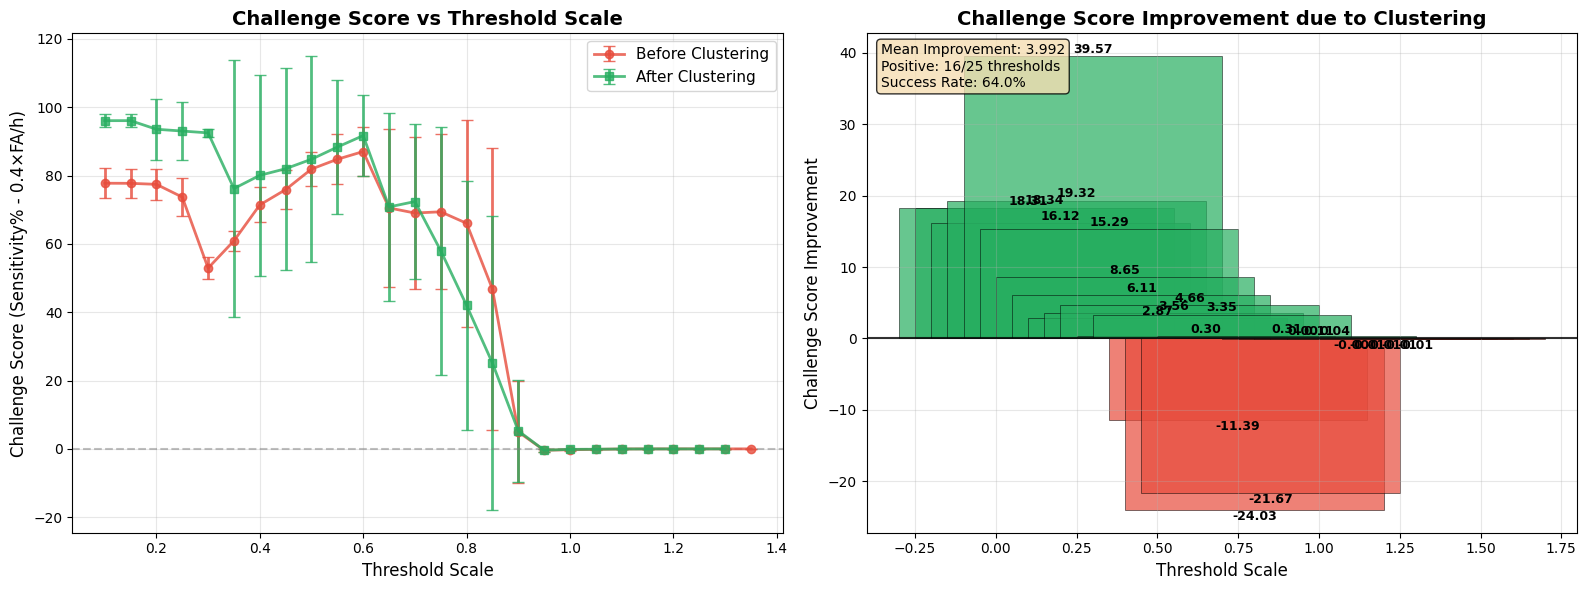


📊 CHALLENGE SCORE SUMMARY BY THRESHOLD
 Threshold  Pre Mean  Pre Std  Post Mean  Post Std  Improvement
     0.100    77.740    4.328     96.051     1.953       18.311
     0.150    77.711    4.330     96.053     1.954       18.342
     0.200    77.413    4.557     93.537     8.966       16.124
     0.250    73.686    5.553     93.011     8.406       19.325
     0.300    52.903    3.223     92.473     1.275       39.570
     0.350    60.898    2.874     76.184    37.644       15.286
     0.400    71.394    5.129     80.047    29.410        8.653
     0.450    75.879    5.609     81.987    29.601        6.108
     0.500    81.892    5.072     84.766    30.197        2.874
     0.550    84.754    7.363     88.319    19.519        3.565
     0.600    87.013    7.093     91.678    11.769        4.665
     0.650    70.509   23.170     70.805    27.597        0.296
     0.700    69.019   22.304     72.373    22.777        3.354
     0.750    69.380   22.692     57.990    36.245      -11.390


In [24]:
# Visualization: Challenge Score vs Threshold Scale
print("📈 CHALLENGE SCORE vs THRESHOLD VISUALIZATION")
print("=" * 60)

if 'df' in locals() and 'challenge_score_pre' in df.columns:
    # Calculate mean challenge scores by threshold scale
    threshold_scores = df.groupby('threshold_scale').agg({
        'challenge_score_pre': ['mean', 'std', 'count'],
        'challenge_score_post': ['mean', 'std', 'count'] if 'challenge_score_post' in df.columns else lambda x: None
    }).round(3)
    
    # Flatten column names
    threshold_scores.columns = ['_'.join(col).strip() for col in threshold_scores.columns]
    threshold_scores = threshold_scores.reset_index()
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Challenge Score vs Threshold Scale
    thresholds = threshold_scores['threshold_scale']
    scores_pre = threshold_scores['challenge_score_pre_mean']
    scores_pre_std = threshold_scores['challenge_score_pre_std']
    
    # Plot before clustering
    ax1.errorbar(thresholds, scores_pre, yerr=scores_pre_std, 
                 marker='o', linewidth=2, markersize=6, capsize=4,
                 label='Before Clustering', color='#e74c3c', alpha=0.8)
    
    # Plot after clustering if available
    if 'challenge_score_post_mean' in threshold_scores.columns:
        scores_post = threshold_scores['challenge_score_post_mean']
        scores_post_std = threshold_scores['challenge_score_post_std']
        
        # Only plot where we have data
        valid_post = ~scores_post.isna()
        if valid_post.any():
            ax1.errorbar(thresholds[valid_post], scores_post[valid_post], 
                        yerr=scores_post_std[valid_post],
                        marker='s', linewidth=2, markersize=6, capsize=4,
                        label='After Clustering', color='#27ae60', alpha=0.8)
    
    ax1.set_xlabel('Threshold Scale', fontsize=12)
    ax1.set_ylabel('Challenge Score (Sensitivity% - 0.4×FA/h)', fontsize=12)
    ax1.set_title('Challenge Score vs Threshold Scale', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Add horizontal line at score = 0 for reference
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Score = 0')
    
    # Plot 2: Improvement due to clustering
    if 'challenge_score_post_mean' in threshold_scores.columns:
        valid_both = ~(scores_pre.isna() | scores_post.isna())
        if valid_both.any():
            improvement = scores_post[valid_both] - scores_pre[valid_both]
            
            # Create bar plot for improvement
            colors = ['#27ae60' if x > 0 else '#e74c3c' for x in improvement]
            bars = ax2.bar(thresholds[valid_both], improvement, 
                          color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add value labels on bars
            for bar, val in zip(bars, improvement):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.02),
                        f'{val:.2f}', ha='center', va='bottom' if height >= 0 else 'top', 
                        fontsize=9, fontweight='bold')
            
            ax2.set_xlabel('Threshold Scale', fontsize=12)
            ax2.set_ylabel('Challenge Score Improvement', fontsize=12)
            ax2.set_title('Challenge Score Improvement due to Clustering', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8)
            
            # Calculate and display summary statistics
            mean_improvement = improvement.mean()
            positive_improvements = (improvement > 0).sum()
            total_thresholds = len(improvement)
            
            # Add text box with statistics
            stats_text = f'Mean Improvement: {mean_improvement:.3f}\n'
            stats_text += f'Positive: {positive_improvements}/{total_thresholds} thresholds\n'
            stats_text += f'Success Rate: {positive_improvements/total_thresholds*100:.1f}%'
            
            ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax2.text(0.5, 0.5, 'No clustering data available\nfor comparison', 
                    transform=ax2.transAxes, ha='center', va='center', fontsize=12)
            ax2.set_title('Challenge Score Improvement due to Clustering', fontsize=14, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No clustering data available', 
                transform=ax2.transAxes, ha='center', va='center', fontsize=12)
        ax2.set_title('Challenge Score Improvement due to Clustering', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"\n📊 CHALLENGE SCORE SUMMARY BY THRESHOLD")
    print("=" * 80)
    
    # Create a nice summary table
    summary_cols = ['threshold_scale', 'challenge_score_pre_mean', 'challenge_score_pre_std']
    if 'challenge_score_post_mean' in threshold_scores.columns:
        summary_cols.extend(['challenge_score_post_mean', 'challenge_score_post_std'])
        
        # Calculate improvement where both are available
        valid_mask = ~(threshold_scores['challenge_score_pre_mean'].isna() | 
                      threshold_scores['challenge_score_post_mean'].isna())
        threshold_scores.loc[valid_mask, 'improvement'] = (
            threshold_scores.loc[valid_mask, 'challenge_score_post_mean'] - 
            threshold_scores.loc[valid_mask, 'challenge_score_pre_mean']
        )
        summary_cols.append('improvement')
    
    display_table = threshold_scores[summary_cols].copy()
    
    # Rename columns for better display
    display_table.columns = ['Threshold', 'Pre Mean', 'Pre Std', 'Post Mean', 'Post Std', 'Improvement'][:len(display_table.columns)]
    
    print(display_table.to_string(index=False, float_format='%.3f'))
    
    # Find best and worst thresholds
    best_pre_idx = scores_pre.idxmax()
    worst_pre_idx = scores_pre.idxmin()
    
    print(f"\n🏆 BEST/WORST THRESHOLDS (Before Clustering):")
    print(f"   Best: {thresholds.iloc[best_pre_idx]:.2f} (Score: {scores_pre.iloc[best_pre_idx]:.3f})")
    print(f"   Worst: {thresholds.iloc[worst_pre_idx]:.2f} (Score: {scores_pre.iloc[worst_pre_idx]:.3f})")
    
    if 'challenge_score_post_mean' in threshold_scores.columns:
        valid_post_scores = scores_post.dropna()
        if len(valid_post_scores) > 0:
            best_post_idx = valid_post_scores.idxmax()
            worst_post_idx = valid_post_scores.idxmin()
            
            print(f"\n🏆 BEST/WORST THRESHOLDS (After Clustering):")
            print(f"   Best: {thresholds.iloc[best_post_idx]:.2f} (Score: {scores_post.iloc[best_post_idx]:.3f})")
            print(f"   Worst: {thresholds.iloc[worst_post_idx]:.2f} (Score: {scores_post.iloc[worst_post_idx]:.3f})")

else:
    print("❌ Challenge score data not available. Please run the challenge score calculation cell first.")

In [25]:
# Data exploration and overview
if 'df' in locals():
    print("📊 DATA OVERVIEW")
    print("=" * 60)
    
    # Basic statistics
    print(f"Total evaluations: {len(df)}")
    print(f"Datasets: {df['dataset_id'].nunique()}")
    print(f"Threshold scales: {sorted(df['threshold_scale'].unique())}")
    
    # Check if we have the correct responder columns
    responder_cols = [col for col in df.columns if 'responder' in col.lower()]
    print(f"\nAvailable responder columns: {responder_cols}")
    
    # Seizure analysis (datasets with actual seizures)
    if 'has_seizures' in df.columns:
        seizure_datasets = df[df['has_seizures'] == True]['dataset_id'].nunique()
        no_seizure_datasets = df[df['has_seizures'] == False]['dataset_id'].nunique()
        print(f"\nDataset breakdown by seizure presence:")
        print(f"  Datasets with seizures: {seizure_datasets}")
        print(f"  Datasets without seizures: {no_seizure_datasets}")
        print(f"  Seizure ratio: {seizure_datasets/(seizure_datasets+no_seizure_datasets):.3f}")
    
    # Responder analysis (pre-clustering)
    if 'is_responder_pre' in df.columns:
        # Only analyze datasets with seizures for responder status
        seizure_data = df[df['has_seizures'] == True] if 'has_seizures' in df.columns else df
        
        responder_analysis = []
        for scale in sorted(seizure_data['threshold_scale'].unique()):
            scale_data = seizure_data[seizure_data['threshold_scale'] == scale]
            n_responders = scale_data['is_responder_pre'].sum()
            n_total = len(scale_data)
            responder_analysis.append({
                'threshold_scale': scale,
                'n_responders_pre': n_responders,
                'n_total_with_seizures': n_total,
                'responder_ratio_pre': n_responders / n_total if n_total > 0 else 0
            })
        
        print(f"\nResponder Analysis (Pre-clustering, sensitivity >2/3):")
        print(f"  Definition: Datasets with seizures AND event_recall > 2/3")
        for analysis in responder_analysis[:5]:  # Show first 5 thresholds
            print(f"  Scale {analysis['threshold_scale']:.2f}: {analysis['n_responders_pre']}/{analysis['n_total_with_seizures']} "
                  f"({analysis['responder_ratio_pre']:.3f})")
        print(f"  ... (showing first 5 thresholds)")
        
        # Overall responder statistics
        total_responder_evaluations_pre = seizure_data['is_responder_pre'].sum()
        total_seizure_evaluations = len(seizure_data)
        print(f"  Overall pre-clustering responders: {total_responder_evaluations_pre}/{total_seizure_evaluations} "
              f"({total_responder_evaluations_pre/total_seizure_evaluations:.3f})")
    
    # Post-clustering responder analysis
    if 'is_responder_post' in df.columns:
        clustered_data = df.dropna(subset=['is_responder_post'])
        if len(clustered_data) > 0:
            total_responder_evaluations_post = clustered_data['is_responder_post'].sum()
            total_clustered_evaluations = len(clustered_data)
            print(f"  Overall post-clustering responders: {total_responder_evaluations_post}/{total_clustered_evaluations} "
                  f"({total_responder_evaluations_post/total_clustered_evaluations:.3f})")
            
            # Calculate responder change due to clustering
            # For evaluations where both pre and post are available
            both_available = df.dropna(subset=['is_responder_pre', 'is_responder_post'])
            if len(both_available) > 0:
                responder_gained = ((both_available['is_responder_pre'] == False) & 
                                   (both_available['is_responder_post'] == True)).sum()
                responder_lost = ((both_available['is_responder_pre'] == True) & 
                                 (both_available['is_responder_post'] == False)).sum()
                print(f"  Clustering impact: +{responder_gained} responders gained, -{responder_lost} responders lost")
    
    # Show first few rows
    print(f"\n📋 SAMPLE DATA")
    print("=" * 60)
    display_cols = ['dataset_id', 'threshold_scale', 'n_true_anomalies', 'event_recall', 'false_alarm_rate_per_hour']
    if 'has_seizures' in df.columns:
        display_cols.append('has_seizures')
    if 'is_responder_pre' in df.columns:
        display_cols.append('is_responder_pre')
    if 'cluster_event_recall' in df.columns:
        display_cols.extend(['cluster_event_recall', 'cluster_event_far_per_hour'])
    if 'is_responder_post' in df.columns:
        display_cols.append('is_responder_post')
    
    available_cols = [col for col in display_cols if col in df.columns]
    print(df[available_cols].head(10))
    
    # Show column info
    print(f"\n📝 COLUMN INFORMATION")
    print("=" * 60)
    print(f"Columns ({len(df.columns)}):")
    for i, col in enumerate(df.columns):
        print(f"  {i+1:2d}. {col}")
else:
    print("❌ Data not loaded. Please run the data loading cell first.")

📊 DATA OVERVIEW
Total evaluations: 338
Datasets: 13
Threshold scales: [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35]

Available responder columns: ['is_responder_pre', 'is_responder_post']

Dataset breakdown by seizure presence:
  Datasets with seizures: 13
  Datasets without seizures: 0
  Seizure ratio: 1.000

Responder Analysis (Pre-clustering, sensitivity >2/3):
  Definition: Datasets with seizures AND event_recall > 2/3
  Scale 0.10: 13/13 (1.000)
  Scale 0.15: 13/13 (1.000)
  Scale 0.20: 13/13 (1.000)
  Scale 0.25: 13/13 (1.000)
  Scale 0.30: 13/13 (1.000)
  ... (showing first 5 thresholds)
  Overall pre-clustering responders: 175/338 (0.518)
  Overall post-clustering responders: 155/289 (0.536)
  Clustering impact: +0 responders gained, -20 responders lost

📋 SAMPLE DATA
   dataset_id  threshold_scale  n_true_anomalies  event_recall  \
0           1             0.10             17928 

In [26]:
df.columns

Index(['dataset_id', 'threshold_scale', 'n_samples', 'n_true_anomalies',
       'anomaly_percentage', 'has_seizures', 'is_responder_pre', 'tp_events',
       'fn_events', 'fp_events', 'event_recall', 'event_sensitivity',
       'event_iou', 'false_alarm_rate_per_hour', 'predicted_samples',
       'predicted_percentage', 'processing_timestamp', 'clustering_strategy',
       'n_clusters', 'n_representatives', 'cluster_event_recall',
       'cluster_event_iou', 'cluster_event_far_per_hour', 'is_responder_post',
       'challenge_score_pre', 'challenge_score_post'],
      dtype='object')

In [27]:
df[['dataset_id','is_responder_pre', 'threshold_scale','n_true_anomalies',  'event_recall', 'false_alarm_rate_per_hour', 'is_responder_post', 'cluster_event_recall',
       'cluster_event_far_per_hour']].head(15)

,dataset_id,is_responder_pre,threshold_scale,n_true_anomalies,event_recall,false_alarm_rate_per_hour,is_responder_post,cluster_event_recall,cluster_event_far_per_hour
0,1,True,0.10,17928,1.00,37.054298,True,1.00,9.270612
1,1,True,0.15,17928,1.00,37.185662,True,1.00,9.317528
2,1,True,0.20,17928,1.00,38.095834,True,1.00,9.430126
3,1,True,0.25,17928,1.00,51.504441,True,1.00,11.653947
4,1,True,0.30,17928,1.00,98.204679,True,1.00,23.448643
5,1,True,0.35,17928,1.00,88.427374,True,1.00,11.972976
6,1,True,0.40,17928,1.00,79.457025,True,1.00,10.255849
7,1,True,0.45,17928,1.00,78.706368,True,1.00,6.877893
8,1,True,0.50,17928,1.00,67.774928,True,1.00,6.830977
9,1,True,0.55,17928,1.00,60.587389,True,0.75,3.584386


## 1. Performance Analysis by Threshold Scale

This section analyzes mean recall and false alarm rates across different threshold scales, comparing performance before and after clustering.

In [28]:
# Performance Analysis by Threshold Scale with Pre-calculated Responder Status
if 'df' in locals():
    # Check if we have the updated responder columns
    if 'is_responder_pre' not in df.columns:
        print("❌ This analysis requires updated batch evaluation results with proper responder calculation.")
        print("   Please re-run the batch evaluation to get 'is_responder_pre' and 'is_responder_post' columns.")
        print("   Current columns:", [col for col in df.columns if 'responder' in col.lower()])
    else:
        print("🎯 THRESHOLD SCALE ANALYSIS WITH CORRECTED RESPONDER DEFINITION")
        print("=" * 80)
        print("Responder definition: Datasets with seizures AND sensitivity (event_recall) > 2/3")
        
        # Group by threshold scale and calculate summary statistics
        threshold_stats = []
        
        for scale in sorted(df['threshold_scale'].unique()):
            scale_data = df[df['threshold_scale'] == scale]
            
            # Filter to datasets with seizures for responder analysis
            seizure_data = scale_data[scale_data['has_seizures'] == True] if 'has_seizures' in df.columns else scale_data
            
            # Pre-clustering responder classification
            responder_pre_data = seizure_data[seizure_data['is_responder_pre'] == True]
            non_responder_pre_data = seizure_data[seizure_data['is_responder_pre'] == False]
            
            # Post-clustering responder classification (only where clustering data exists)
            clustering_data = scale_data.dropna(subset=['cluster_event_recall']) if 'cluster_event_recall' in scale_data.columns else pd.DataFrame()
            clustering_seizure_data = clustering_data[clustering_data['has_seizures'] == True] if len(clustering_data) > 0 and 'has_seizures' in clustering_data.columns else clustering_data
            
            if len(clustering_seizure_data) > 0 and 'is_responder_post' in clustering_seizure_data.columns:
                responder_post_data = clustering_seizure_data[clustering_seizure_data['is_responder_post'] == True]
                non_responder_post_data = clustering_seizure_data[clustering_seizure_data['is_responder_post'] == False]
            else:
                responder_post_data = pd.DataFrame()
                non_responder_post_data = pd.DataFrame()
            
            # Check if clustering data exists
            has_clustering = len(clustering_data) > 0
            
            stats = {
                'threshold_scale': scale,
                'n_datasets_total': len(scale_data),
                'n_datasets_with_seizures': len(seizure_data),
                
                # Pre-clustering responders (among datasets with seizures)
                'n_responders_pre': len(responder_pre_data),
                'n_non_responders_pre': len(non_responder_pre_data),
                'responder_ratio_pre': len(responder_pre_data) / len(seizure_data) if len(seizure_data) > 0 else 0,
                
                # Before clustering (all datasets with seizures)
                'mean_recall_before_seizures': seizure_data['event_recall'].mean() if len(seizure_data) > 0 else np.nan,
                'std_recall_before_seizures': seizure_data['event_recall'].std() if len(seizure_data) > 0 else np.nan,
                'mean_far_before_all': scale_data['false_alarm_rate_per_hour'].mean(),
                'std_far_before_all': scale_data['false_alarm_rate_per_hour'].std(),
                
                # Before clustering (pre-clustering responders only)
                'mean_recall_before_resp': responder_pre_data['event_recall'].mean() if len(responder_pre_data) > 0 else np.nan,
                'std_recall_before_resp': responder_pre_data['event_recall'].std() if len(responder_pre_data) > 0 else np.nan,
                'mean_far_before_resp': responder_pre_data['false_alarm_rate_per_hour'].mean() if len(responder_pre_data) > 0 else np.nan,
                'std_far_before_resp': responder_pre_data['false_alarm_rate_per_hour'].std() if len(responder_pre_data) > 0 else np.nan,
                
                # Before clustering (pre-clustering non-responders only)
                'mean_recall_before_nonresp': non_responder_pre_data['event_recall'].mean() if len(non_responder_pre_data) > 0 else np.nan,
                'std_recall_before_nonresp': non_responder_pre_data['event_recall'].std() if len(non_responder_pre_data) > 0 else np.nan,
                'mean_far_before_nonresp': non_responder_pre_data['false_alarm_rate_per_hour'].mean() if len(non_responder_pre_data) > 0 else np.nan,
                'std_far_before_nonresp': non_responder_pre_data['false_alarm_rate_per_hour'].std() if len(non_responder_pre_data) > 0 else np.nan,
            }
            
            # Add clustering statistics if available
            if has_clustering:
                stats.update({
                    # Post-clustering responders (among datasets with seizures)
                    'n_responders_post': len(responder_post_data),
                    'n_non_responders_post': len(non_responder_post_data),
                    'responder_ratio_post': len(responder_post_data) / len(clustering_seizure_data) if len(clustering_seizure_data) > 0 else np.nan,
                    'responder_change': len(responder_post_data) - len(responder_pre_data) if len(clustering_seizure_data) > 0 else np.nan,
                    
                    # After clustering (all datasets)
                    'mean_recall_after_all': clustering_data['cluster_event_recall'].mean(),
                    'std_recall_after_all': clustering_data['cluster_event_recall'].std(),
                    'mean_far_after_all': clustering_data['cluster_event_far_per_hour'].mean(),
                    'std_far_after_all': clustering_data['cluster_event_far_per_hour'].std(),
                    
                    # After clustering (post-clustering responders only)
                    'mean_recall_after_resp': responder_post_data['cluster_event_recall'].mean() if len(responder_post_data) > 0 else np.nan,
                    'std_recall_after_resp': responder_post_data['cluster_event_recall'].std() if len(responder_post_data) > 0 else np.nan,
                    'mean_far_after_resp': responder_post_data['cluster_event_far_per_hour'].mean() if len(responder_post_data) > 0 else np.nan,
                    'std_far_after_resp': responder_post_data['cluster_event_far_per_hour'].std() if len(responder_post_data) > 0 else np.nan,
                    
                    # After clustering (post-clustering non-responders only)
                    'mean_recall_after_nonresp': non_responder_post_data['cluster_event_recall'].mean() if len(non_responder_post_data) > 0 else np.nan,
                    'std_recall_after_nonresp': non_responder_post_data['cluster_event_recall'].std() if len(non_responder_post_data) > 0 else np.nan,
                    'mean_far_after_nonresp': non_responder_post_data['cluster_event_far_per_hour'].mean() if len(non_responder_post_data) > 0 else np.nan,
                    'std_far_after_nonresp': non_responder_post_data['cluster_event_far_per_hour'].std() if len(non_responder_post_data) > 0 else np.nan,
                    
                    # Clustering effectiveness
                    'mean_recall_change': (clustering_data['cluster_event_recall'] - clustering_data['event_recall']).mean(),
                    'mean_far_reduction': (clustering_data['false_alarm_rate_per_hour'] - clustering_data['cluster_event_far_per_hour']).mean(),
                    'n_clustered': len(clustering_data)
                })
            else:
                # Fill with NaN if no clustering data
                for key in ['n_responders_post', 'n_non_responders_post', 'responder_ratio_post', 'responder_change',
                           'mean_recall_after_all', 'std_recall_after_all', 'mean_far_after_all', 'std_far_after_all',
                           'mean_recall_after_resp', 'std_recall_after_resp', 'mean_far_after_resp', 'std_far_after_resp',
                           'mean_recall_after_nonresp', 'std_recall_after_nonresp', 'mean_far_after_nonresp', 'std_far_after_nonresp', 
                           'mean_recall_change', 'mean_far_reduction', 'n_clustered']:
                    stats[key] = np.nan
            
            threshold_stats.append(stats)
        
        # Convert to DataFrame for easier analysis
        threshold_df = pd.DataFrame(threshold_stats)
        
        print(f"Analyzed {len(threshold_df)} threshold scales")
        print(f"Threshold range: {threshold_df['threshold_scale'].min():.2f} to {threshold_df['threshold_scale'].max():.2f}")
        
        # Display summary table
        display_cols = ['threshold_scale', 'n_datasets_total', 'n_datasets_with_seizures', 'n_responders_pre', 'responder_ratio_pre',
                       'mean_recall_before_seizures', 'mean_far_before_all']
        
        if threshold_df['n_clustered'].notna().any():
            display_cols.extend(['n_responders_post', 'responder_ratio_post', 'responder_change', 
                               'mean_recall_after_all', 'mean_far_after_all'])
        
        print(f"\n📊 Summary Table (first 10 thresholds):")
        display_df = threshold_df[display_cols].head(10).round(3)
        print(display_df.to_string(index=False))
        
        # Show responder trend across thresholds
        print(f"\n📈 RESPONDER TREND ACROSS THRESHOLDS:")
        print("=" * 60)
        responder_trend = threshold_df[['threshold_scale', 'n_responders_pre', 'responder_ratio_pre', 'n_responders_post', 'responder_ratio_post']].copy()
        print("First 10 thresholds:")
        print(responder_trend.head(10).round(3).to_string(index=False))
        
        # Overall statistics
        if len(threshold_df) > 0:
            total_seizure_datasets = threshold_df['n_datasets_with_seizures'].iloc[0]  # Should be same across thresholds
            max_responders_pre = threshold_df['n_responders_pre'].max()
            min_responders_pre = threshold_df['n_responders_pre'].min()
            best_threshold_pre = threshold_df.loc[threshold_df['n_responders_pre'].idxmax(), 'threshold_scale']
            
            print(f"\n🏆 KEY INSIGHTS:")
            print(f"  Total datasets with seizures: {total_seizure_datasets}")
            print(f"  Max responders (pre-clustering): {max_responders_pre}/{total_seizure_datasets} at threshold {best_threshold_pre:.2f}")
            print(f"  Min responders (pre-clustering): {min_responders_pre}/{total_seizure_datasets}")
            print(f"  Responder range: {min_responders_pre}-{max_responders_pre} across thresholds")
            
            if threshold_df['n_responders_post'].notna().any():
                max_responders_post = threshold_df['n_responders_post'].max()
                best_threshold_post = threshold_df.loc[threshold_df['n_responders_post'].idxmax(), 'threshold_scale']
                print(f"  Max responders (post-clustering): {max_responders_post} at threshold {best_threshold_post:.2f}")
                
                # Calculate overall clustering impact on responder count
                total_responder_change = threshold_df['responder_change'].sum()
                print(f"  Overall clustering impact: {total_responder_change:+.0f} responder evaluations gained/lost")

else:
    print("❌ Data not loaded. Please run the data loading cell first.")

🎯 THRESHOLD SCALE ANALYSIS WITH CORRECTED RESPONDER DEFINITION
Responder definition: Datasets with seizures AND sensitivity (event_recall) > 2/3
Analyzed 26 threshold scales
Threshold range: 0.10 to 1.35

📊 Summary Table (first 10 thresholds):
 threshold_scale  n_datasets_total  n_datasets_with_seizures  n_responders_pre  responder_ratio_pre  mean_recall_before_seizures  mean_far_before_all  n_responders_post  responder_ratio_post  responder_change  mean_recall_after_all  mean_far_after_all
            0.10                13                        13                13                  1.0                        1.000               55.651               13.0                 1.000               0.0                  0.995               8.591
            0.15                13                        13                13                  1.0                        1.000               55.723               13.0                 1.000               0.0                  0.995               8.585


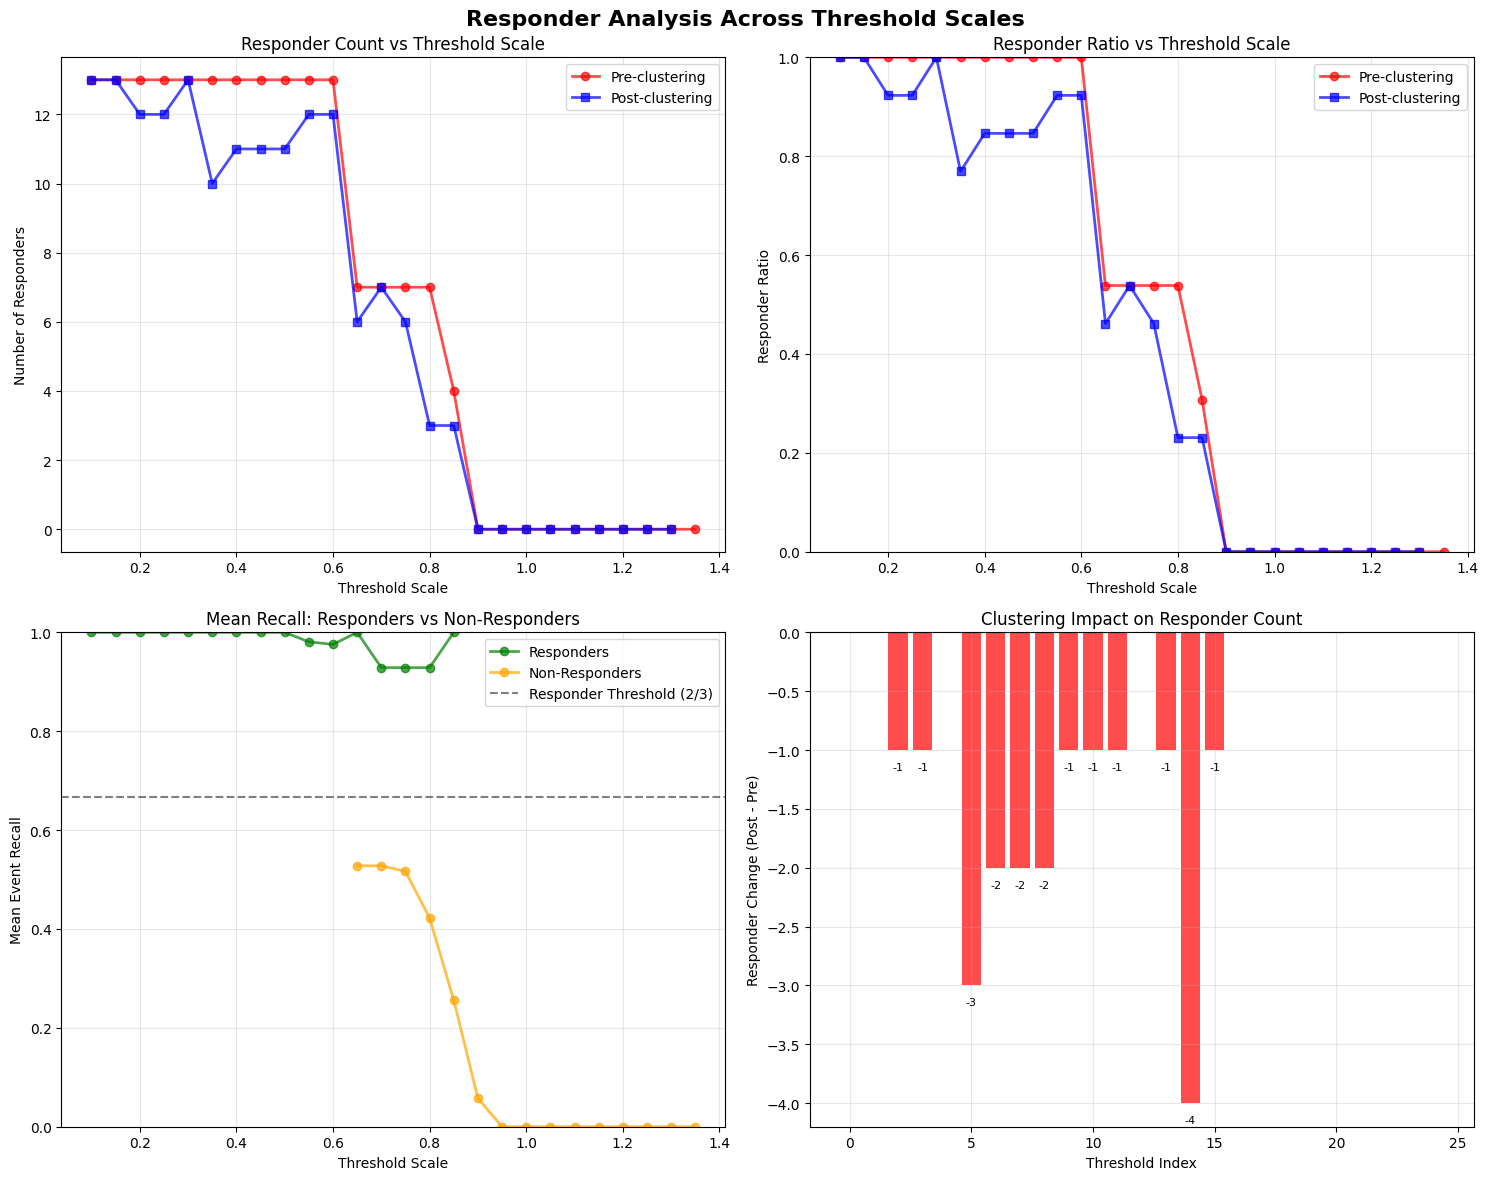


🔍 RESPONDER TREND INSIGHTS:
  High responder rate (>80%): thresholds 0.10-0.60
  Low responder rate (<20%): thresholds 0.90-1.35
  Optimal balance: threshold 0.50 (13 responders, 45.3 FAR/hr)
  Clustering impact: 0 thresholds gained responders, 12 lost responders, 13 unchanged


In [29]:
# Visualize Responder Count Changes Across Thresholds
if 'threshold_df' in locals() and len(threshold_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Responder Analysis Across Threshold Scales', fontsize=16, fontweight='bold')
    
    # 1. Number of Responders vs Threshold
    ax1 = axes[0, 0]
    x = threshold_df['threshold_scale']
    ax1.plot(x, threshold_df['n_responders_pre'], 'o-', color='red', alpha=0.7, label='Pre-clustering', linewidth=2)
    if threshold_df['n_responders_post'].notna().any():
        ax1.plot(x, threshold_df['n_responders_post'], 's-', color='blue', alpha=0.7, label='Post-clustering', linewidth=2)
    ax1.set_xlabel('Threshold Scale')
    ax1.set_ylabel('Number of Responders')
    ax1.set_title('Responder Count vs Threshold Scale')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Responder Ratio vs Threshold
    ax2 = axes[0, 1]
    ax2.plot(x, threshold_df['responder_ratio_pre'], 'o-', color='red', alpha=0.7, label='Pre-clustering', linewidth=2)
    if threshold_df['responder_ratio_post'].notna().any():
        ax2.plot(x, threshold_df['responder_ratio_post'], 's-', color='blue', alpha=0.7, label='Post-clustering', linewidth=2)
    ax2.set_xlabel('Threshold Scale')
    ax2.set_ylabel('Responder Ratio')
    ax2.set_title('Responder Ratio vs Threshold Scale')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # 3. Mean Recall for Responders vs Non-Responders
    ax3 = axes[1, 0]
    ax3.plot(x, threshold_df['mean_recall_before_resp'], 'o-', color='green', alpha=0.7, label='Responders', linewidth=2)
    ax3.plot(x, threshold_df['mean_recall_before_nonresp'], 'o-', color='orange', alpha=0.7, label='Non-Responders', linewidth=2)
    ax3.axhline(y=2/3, color='black', linestyle='--', alpha=0.5, label='Responder Threshold (2/3)')
    ax3.set_xlabel('Threshold Scale')
    ax3.set_ylabel('Mean Event Recall')
    ax3.set_title('Mean Recall: Responders vs Non-Responders')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # 4. Responder Change due to Clustering
    if threshold_df['responder_change'].notna().any():
        ax4 = axes[1, 1]
        colors = ['green' if x >= 0 else 'red' for x in threshold_df['responder_change']]
        bars = ax4.bar(range(len(x)), threshold_df['responder_change'], color=colors, alpha=0.7)
        ax4.set_xlabel('Threshold Index')
        ax4.set_ylabel('Responder Change (Post - Pre)')
        ax4.set_title('Clustering Impact on Responder Count')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if abs(height) > 0.1:  # Only label significant changes
                ax4.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.1),
                        f'{height:+.0f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    else:
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, 'No clustering data available\nfor responder change analysis', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Clustering Impact on Responder Count')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights about responder trends
    print(f"\n🔍 RESPONDER TREND INSIGHTS:")
    print("=" * 50)
    
    # Find threshold ranges with different responder characteristics
    if len(threshold_df) > 0:
        # High responder thresholds (>80% responder ratio)
        high_responder_thresholds = threshold_df[threshold_df['responder_ratio_pre'] > 0.8]['threshold_scale']
        if len(high_responder_thresholds) > 0:
            print(f"  High responder rate (>80%): thresholds {high_responder_thresholds.min():.2f}-{high_responder_thresholds.max():.2f}")
        
        # Low responder thresholds (<20% responder ratio)
        low_responder_thresholds = threshold_df[threshold_df['responder_ratio_pre'] < 0.2]['threshold_scale']
        if len(low_responder_thresholds) > 0:
            print(f"  Low responder rate (<20%): thresholds {low_responder_thresholds.min():.2f}-{low_responder_thresholds.max():.2f}")
        
        # Optimal balance threshold (highest responder count with reasonable FAR)
        reasonable_far_mask = threshold_df['mean_far_before_all'] < 50  # Less than 50 false alarms per hour
        if reasonable_far_mask.any():
            optimal_candidates = threshold_df[reasonable_far_mask]
            best_balance_idx = optimal_candidates['n_responders_pre'].idxmax()
            best_balance_threshold = optimal_candidates.loc[best_balance_idx, 'threshold_scale']
            best_balance_responders = optimal_candidates.loc[best_balance_idx, 'n_responders_pre']
            best_balance_far = optimal_candidates.loc[best_balance_idx, 'mean_far_before_all']
            print(f"  Optimal balance: threshold {best_balance_threshold:.2f} ({best_balance_responders} responders, {best_balance_far:.1f} FAR/hr)")
        
        # Clustering impact summary
        if threshold_df['responder_change'].notna().any():
            positive_changes = (threshold_df['responder_change'] > 0).sum()
            negative_changes = (threshold_df['responder_change'] < 0).sum()
            no_change = (threshold_df['responder_change'] == 0).sum()
            
            print(f"  Clustering impact: {positive_changes} thresholds gained responders, "
                  f"{negative_changes} lost responders, {no_change} unchanged")
            
            if positive_changes > 0:
                max_gain = threshold_df['responder_change'].max()
                max_gain_threshold = threshold_df.loc[threshold_df['responder_change'].idxmax(), 'threshold_scale']
                print(f"  Biggest gain: +{max_gain:.0f} responders at threshold {max_gain_threshold:.2f}")

else:
    print("❌ Threshold analysis not completed. Please run the previous cell first.")

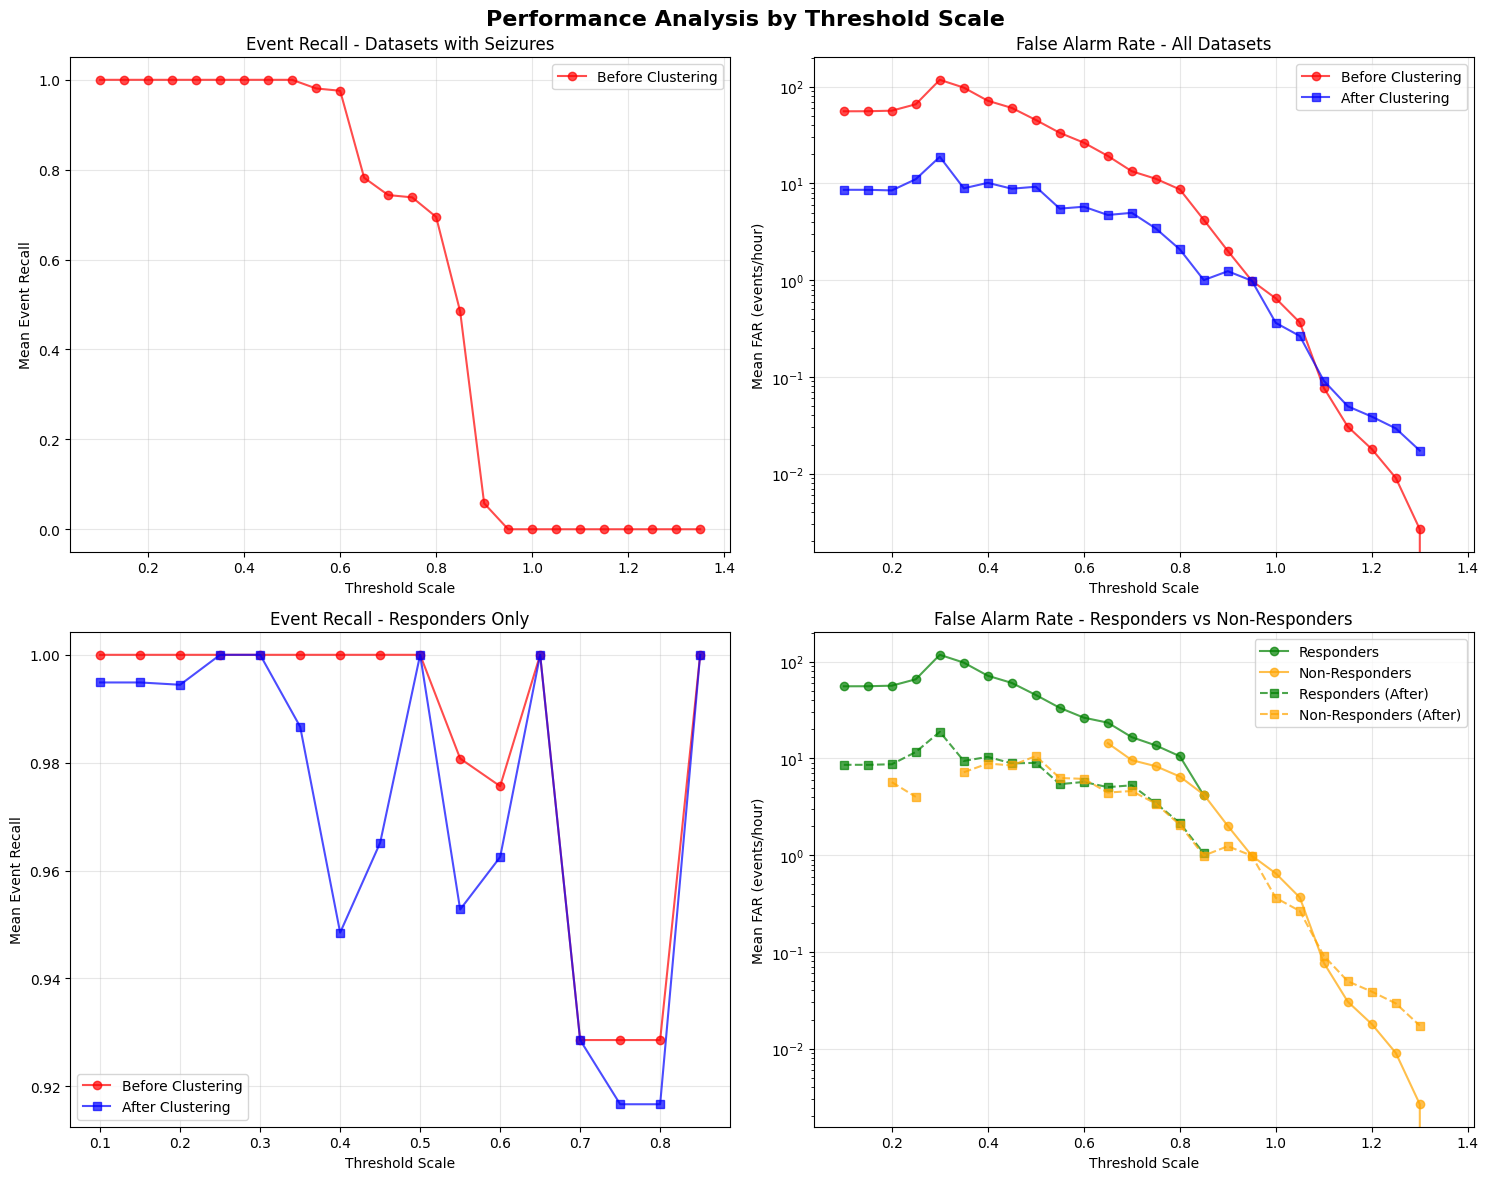


📈 THRESHOLD ANALYSIS SUMMARY:
Best recall threshold: 0.10 (recall: 1.000)
Best balance threshold: 0.80 (recall: 0.695, FAR: 8.7/hr)
Maximum responders: 13 at threshold 0.10


In [30]:
# Visualizations for Threshold Analysis
if 'threshold_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Performance Analysis by Threshold Scale', fontsize=16, fontweight='bold')
    
    # 1. Recall Before vs After Clustering (All Datasets with Seizures)
    axes[0,0].plot(threshold_df['threshold_scale'], threshold_df['mean_recall_before_seizures'], 
                   'o-', label='Before Clustering', color='red', alpha=0.7)
    if 'mean_recall_after_seizures' in threshold_df.columns and threshold_df['mean_recall_after_seizures'].notna().any():
        axes[0,0].plot(threshold_df['threshold_scale'], threshold_df['mean_recall_after_seizures'], 
                       's-', label='After Clustering', color='blue', alpha=0.7)
    axes[0,0].set_xlabel('Threshold Scale')
    axes[0,0].set_ylabel('Mean Event Recall')
    axes[0,0].set_title('Event Recall - Datasets with Seizures')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. FAR Before vs After Clustering (All Datasets) 
    axes[0,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_before_all'], 
                   'o-', label='Before Clustering', color='red', alpha=0.7)
    if 'mean_far_after_all' in threshold_df.columns and threshold_df['mean_far_after_all'].notna().any():
        axes[0,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_after_all'], 
                       's-', label='After Clustering', color='blue', alpha=0.7)
    axes[0,1].set_xlabel('Threshold Scale')
    axes[0,1].set_ylabel('Mean FAR (events/hour)')
    axes[0,1].set_title('False Alarm Rate - All Datasets')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_yscale('log')  # Log scale for better visibility
    
    # 3. Responders Only - Recall
    if 'mean_recall_before_resp' in threshold_df.columns:
        axes[1,0].plot(threshold_df['threshold_scale'], threshold_df['mean_recall_before_resp'], 
                       'o-', label='Before Clustering', color='red', alpha=0.7)
        if 'mean_recall_after_resp' in threshold_df.columns and threshold_df['mean_recall_after_resp'].notna().any():
            axes[1,0].plot(threshold_df['threshold_scale'], threshold_df['mean_recall_after_resp'], 
                           's-', label='After Clustering', color='blue', alpha=0.7)
        axes[1,0].set_xlabel('Threshold Scale')
        axes[1,0].set_ylabel('Mean Event Recall')
        axes[1,0].set_title('Event Recall - Responders Only')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'Responder-specific recall data\nnot available', 
                      ha='center', va='center', transform=axes[1,0].transAxes, fontsize=12)
        axes[1,0].set_title('Event Recall - Responders Only')
    
    # 4. Responders vs Non-Responders FAR
    if 'mean_far_before_resp' in threshold_df.columns and 'mean_far_before_nonresp' in threshold_df.columns:
        axes[1,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_before_resp'], 
                       'o-', label='Responders', color='green', alpha=0.7)
        axes[1,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_before_nonresp'], 
                       'o-', label='Non-Responders', color='orange', alpha=0.7)
        if 'mean_far_after_resp' in threshold_df.columns and threshold_df['mean_far_after_resp'].notna().any():
            axes[1,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_after_resp'], 
                           's-', label='Responders (After)', color='green', alpha=0.7, linestyle='--')
        if 'mean_far_after_nonresp' in threshold_df.columns and threshold_df['mean_far_after_nonresp'].notna().any():
            axes[1,1].plot(threshold_df['threshold_scale'], threshold_df['mean_far_after_nonresp'], 
                           's-', label='Non-Responders (After)', color='orange', alpha=0.7, linestyle='--')
        axes[1,1].set_xlabel('Threshold Scale')
        axes[1,1].set_ylabel('Mean FAR (events/hour)')
        axes[1,1].set_title('False Alarm Rate - Responders vs Non-Responders')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_yscale('log')  # Log scale for better visibility
    else:
        axes[1,1].text(0.5, 0.5, 'Responder-specific FAR data\nnot available', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('False Alarm Rate - Responders vs Non-Responders')
    
    plt.tight_layout()
    plt.show()
    
    # Performance Analysis Summary
    print(f"\n📈 THRESHOLD ANALYSIS SUMMARY:")
    print("=" * 60)
    
    # Find optimal thresholds
    if 'mean_recall_before_seizures' in threshold_df.columns:
        # Best recall threshold
        best_recall_idx = threshold_df['mean_recall_before_seizures'].idxmax()
        best_recall_threshold = threshold_df.loc[best_recall_idx, 'threshold_scale']
        best_recall_value = threshold_df.loc[best_recall_idx, 'mean_recall_before_seizures']
        print(f"Best recall threshold: {best_recall_threshold:.2f} (recall: {best_recall_value:.3f})")
        
        # Best balance (high recall, reasonable FAR)
        reasonable_recall_mask = threshold_df['mean_recall_before_seizures'] > 0.5
        if reasonable_recall_mask.any():
            candidates = threshold_df[reasonable_recall_mask]
            best_balance_idx = candidates['mean_far_before_all'].idxmin()
            best_balance_threshold = candidates.loc[best_balance_idx, 'threshold_scale']
            best_balance_recall = candidates.loc[best_balance_idx, 'mean_recall_before_seizures']
            best_balance_far = candidates.loc[best_balance_idx, 'mean_far_before_all']
            print(f"Best balance threshold: {best_balance_threshold:.2f} (recall: {best_balance_recall:.3f}, FAR: {best_balance_far:.1f}/hr)")
    
    # Responder statistics
    if 'n_responders_pre' in threshold_df.columns:
        max_responders = threshold_df['n_responders_pre'].max()
        max_responders_threshold = threshold_df.loc[threshold_df['n_responders_pre'].idxmax(), 'threshold_scale']
        print(f"Maximum responders: {max_responders} at threshold {max_responders_threshold:.2f}")

else:
    print("❌ Threshold analysis not completed. Please run the previous cell first.")

## 2. Clustering Strategy Analysis

This section analyzes which clustering strategies are most frequently selected across different threshold scales and their effectiveness.

In [31]:
# Clustering Strategy Analysis
if 'df' in locals() and 'clustering_strategy' in df.columns:
    # Filter data with clustering results
    clustered_data = df.dropna(subset=['clustering_strategy'])
    
    if len(clustered_data) > 0:
        print("🔧 CLUSTERING STRATEGY ANALYSIS")
        print("=" * 70)
        print(f"Total evaluations with clustering: {len(clustered_data)}")
        
        # Overall strategy frequency
        strategy_counts = clustered_data['clustering_strategy'].value_counts()
        strategy_pct = (strategy_counts / len(clustered_data) * 100).round(1)
        
        print(f"\n📊 Most Used Clustering Strategies (Overall):")
        print("-" * 50)
        for strategy, count in strategy_counts.head(10).items():
            pct = strategy_pct[strategy]
            print(f"  {strategy:<30} {count:>5} ({pct:>4.1f}%)")
        
        # Strategy frequency by threshold scale
        print(f"\n📈 Strategy Usage by Threshold Scale:")
        print("-" * 50)
        
        strategy_by_threshold = []
        for scale in sorted(clustered_data['threshold_scale'].unique()):
            scale_data = clustered_data[clustered_data['threshold_scale'] == scale]
            if len(scale_data) > 0:
                top_strategy = scale_data['clustering_strategy'].value_counts().index[0]
                top_count = scale_data['clustering_strategy'].value_counts().iloc[0]
                top_pct = (top_count / len(scale_data) * 100)
                
                strategy_by_threshold.append({
                    'threshold_scale': scale,
                    'top_strategy': top_strategy,
                    'usage_count': top_count,
                    'usage_percentage': top_pct,
                    'total_datasets': len(scale_data)
                })
        
        strategy_threshold_df = pd.DataFrame(strategy_by_threshold)
        
        # Show first 15 thresholds
        print(strategy_threshold_df.head(15).to_string(index=False))
        
        # Strategy effectiveness analysis
        print(f"\n⚡ STRATEGY EFFECTIVENESS ANALYSIS:")
        print("-" * 50)
        
        strategy_effectiveness = []
        for strategy in strategy_counts.head(10).index:
            strategy_data = clustered_data[clustered_data['clustering_strategy'] == strategy]
            
            effectiveness = {
                'strategy': strategy,
                'count': len(strategy_data),
                'mean_recall_change': (strategy_data['cluster_event_recall'] - strategy_data['event_recall']).mean(),
                'mean_far_reduction': (strategy_data['false_alarm_rate_per_hour'] - strategy_data['cluster_event_far_per_hour']).mean(),
                'mean_anomaly_reduction': ((strategy_data['n_representatives'] / (strategy_data['n_representatives'] + 1)) * 100).mean(),  # Approximate
                'mean_final_recall': strategy_data['cluster_event_recall'].mean(),
                'mean_final_far': strategy_data['cluster_event_far_per_hour'].mean()
            }
            strategy_effectiveness.append(effectiveness)
        
        effectiveness_df = pd.DataFrame(strategy_effectiveness)
        effectiveness_df = effectiveness_df.round(3)
        
        print("Strategy Performance Comparison:")
        print(effectiveness_df[['strategy', 'count', 'mean_recall_change', 'mean_far_reduction', 'mean_final_recall']].to_string(index=False))
        
    else:
        print("❌ No clustering data found in the dataset.")
        print("Available columns:", list(df.columns))
        
elif 'df' in locals():
    print("❌ No 'clustering_strategy' column found.")
    print("Available columns:", list(df.columns))
else:
    print("❌ Data not loaded. Please run the data loading cell first.")

🔧 CLUSTERING STRATEGY ANALYSIS
Total evaluations with clustering: 289

📊 Most Used Clustering Strategies (Overall):
--------------------------------------------------
  time_5s                           44 (15.2%)
  fine_time_105s                    39 (13.5%)
  time_90s                          39 (13.5%)
  time_150s                         39 (13.5%)
  time_240s                         26 ( 9.0%)
  time_40s                          13 ( 4.5%)
  fine_time_65s                     13 ( 4.5%)
  time_75s                          13 ( 4.5%)
  time_180s                         13 ( 4.5%)
  extended_time_450s                13 ( 4.5%)

📈 Strategy Usage by Threshold Scale:
--------------------------------------------------
 threshold_scale       top_strategy  usage_count  usage_percentage  total_datasets
            0.10     fine_time_105s           13             100.0              13
            0.15     fine_time_105s           13             100.0              13
            0.20     fine

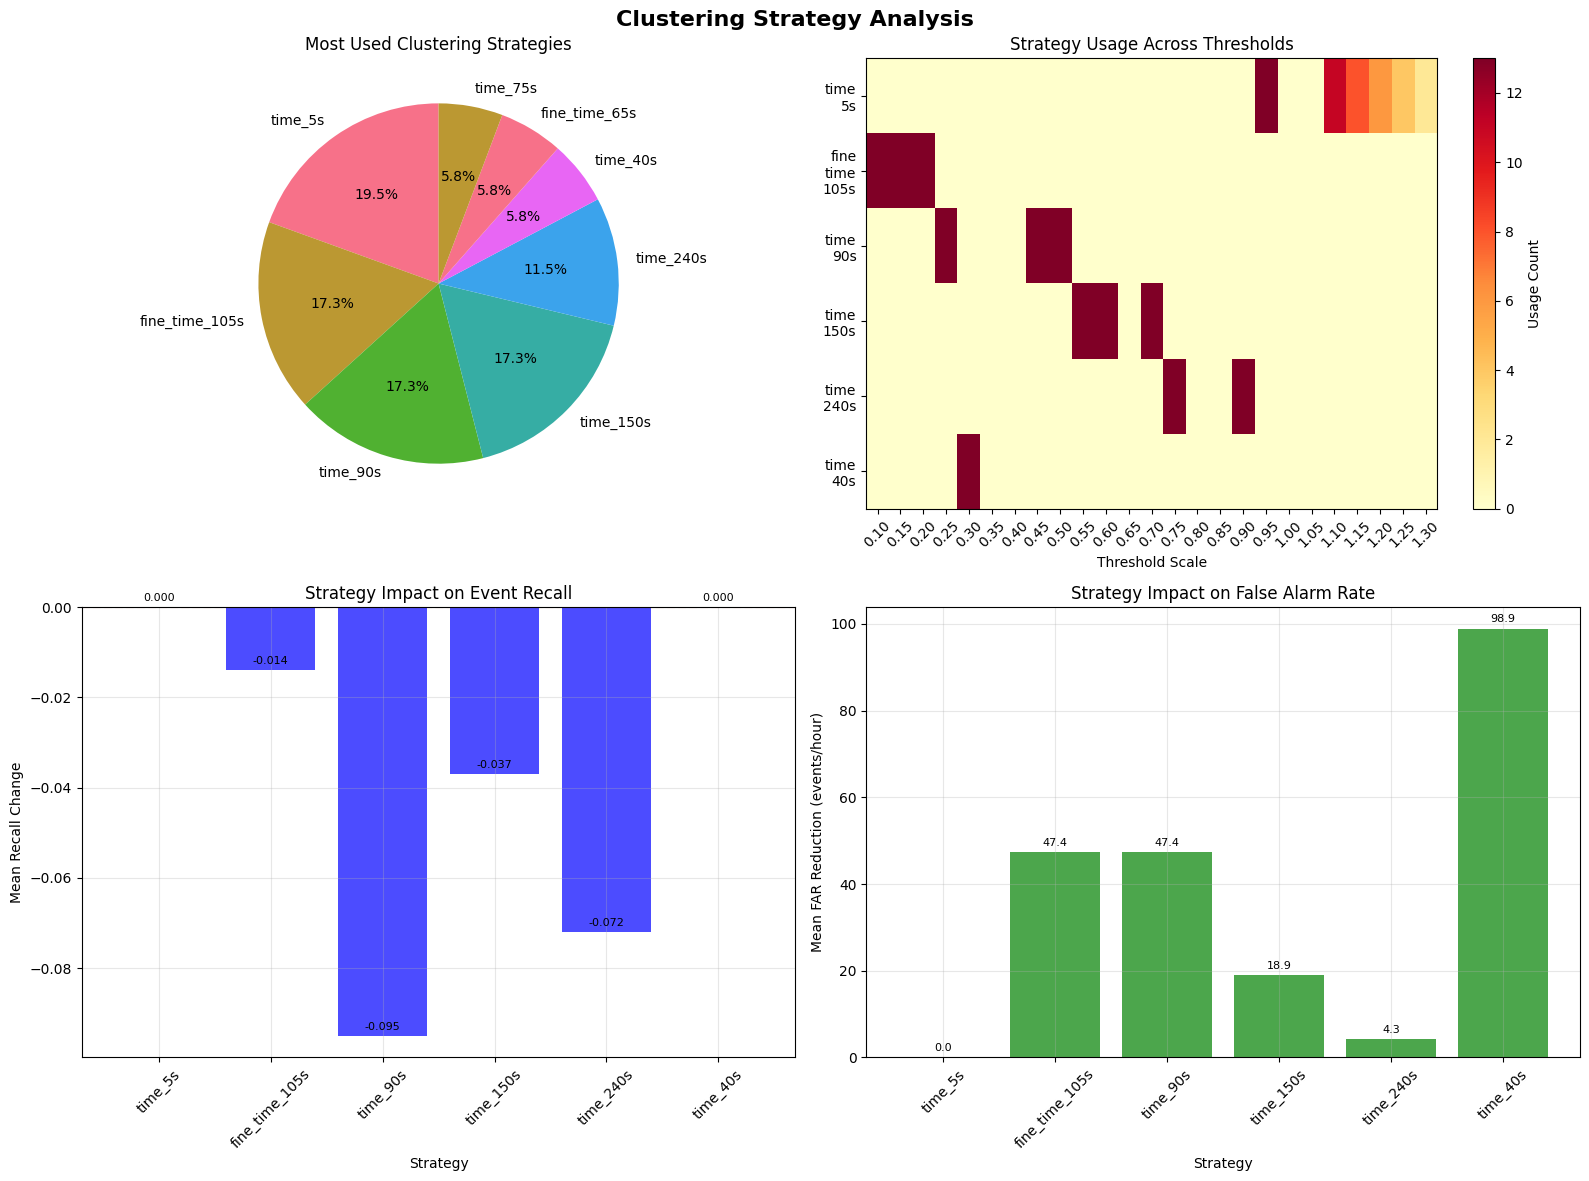


💡 KEY INSIGHTS:
• Most used strategy: 'time_5s' (44 times, 15.2%)
• Best for recall improvement: 'time_5s' (+0.000)
• Best for FAR reduction: 'time_40s' (-98.9 events/hour)
• Overall clustering impact: Recall -0.067, FAR 28.1 events/hour


In [32]:
# Clustering Strategy Visualizations
if 'clustered_data' in locals() and len(clustered_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Clustering Strategy Analysis', fontsize=16, fontweight='bold')
    
    # 1. Strategy Usage Frequency (Overall)
    strategy_counts = clustered_data['clustering_strategy'].value_counts().head(8)
    axes[0,0].pie(strategy_counts.values, labels=strategy_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Most Used Clustering Strategies')
    
    # 2. Strategy Usage by Threshold (Heatmap style)
    if 'strategy_threshold_df' in locals():
        # Create a simplified view of top strategies across thresholds
        threshold_strategy_pivot = clustered_data.pivot_table(
            index='threshold_scale', 
            columns='clustering_strategy', 
            values='dataset_id', 
            aggfunc='count', 
            fill_value=0
        )
        
        # Select top 6 strategies for readability
        top_strategies = strategy_counts.head(6).index
        if len(top_strategies) <= len(threshold_strategy_pivot.columns):
            threshold_subset = threshold_strategy_pivot[top_strategies]
            
            im = axes[0,1].imshow(threshold_subset.T, cmap='YlOrRd', aspect='auto')
            axes[0,1].set_xticks(range(len(threshold_subset.index)))
            axes[0,1].set_xticklabels([f"{x:.2f}" for x in threshold_subset.index], rotation=45)
            axes[0,1].set_yticks(range(len(top_strategies)))
            axes[0,1].set_yticklabels([s.replace('_', '\n') for s in top_strategies])
            axes[0,1].set_title('Strategy Usage Across Thresholds')
            axes[0,1].set_xlabel('Threshold Scale')
            plt.colorbar(im, ax=axes[0,1], label='Usage Count')
    
    # 3. Strategy Effectiveness - Recall Change
    if 'effectiveness_df' in locals():
        top_strategies_eff = effectiveness_df.head(6)
        bars1 = axes[1,0].bar(range(len(top_strategies_eff)), top_strategies_eff['mean_recall_change'], 
                             color='blue', alpha=0.7)
        axes[1,0].set_xlabel('Strategy')
        axes[1,0].set_ylabel('Mean Recall Change')
        axes[1,0].set_title('Strategy Impact on Event Recall')
        axes[1,0].set_xticks(range(len(top_strategies_eff)))
        axes[1,0].set_xticklabels([s[:15] + '...' if len(s) > 15 else s 
                                  for s in top_strategies_eff['strategy']], rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # Add value labels on bars
        for bar, val in zip(bars1, top_strategies_eff['mean_recall_change']):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                          f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. Strategy Effectiveness - FAR Reduction
    if 'effectiveness_df' in locals():
        bars2 = axes[1,1].bar(range(len(top_strategies_eff)), top_strategies_eff['mean_far_reduction'], 
                             color='green', alpha=0.7)
        axes[1,1].set_xlabel('Strategy')
        axes[1,1].set_ylabel('Mean FAR Reduction (events/hour)')
        axes[1,1].set_title('Strategy Impact on False Alarm Rate')
        axes[1,1].set_xticks(range(len(top_strategies_eff)))
        axes[1,1].set_xticklabels([s[:15] + '...' if len(s) > 15 else s 
                                  for s in top_strategies_eff['strategy']], rotation=45)
        axes[1,1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars2, top_strategies_eff['mean_far_reduction']):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_strategies_eff['mean_far_reduction'])*0.01, 
                          f'{val:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    if 'effectiveness_df' in locals() and 'strategy_counts' in locals():
        print(f"\n💡 KEY INSIGHTS:")
        print("=" * 50)
        
        most_used = strategy_counts.index[0]
        most_used_count = strategy_counts.iloc[0]
        most_used_pct = (most_used_count / len(clustered_data) * 100)
        print(f"• Most used strategy: '{most_used}' ({most_used_count} times, {most_used_pct:.1f}%)")
        
        best_recall_strategy = effectiveness_df.loc[effectiveness_df['mean_recall_change'].idxmax(), 'strategy']
        best_recall_change = effectiveness_df['mean_recall_change'].max()
        print(f"• Best for recall improvement: '{best_recall_strategy}' (+{best_recall_change:.3f})")
        
        best_far_strategy = effectiveness_df.loc[effectiveness_df['mean_far_reduction'].idxmax(), 'strategy'] 
        best_far_reduction = effectiveness_df['mean_far_reduction'].max()
        print(f"• Best for FAR reduction: '{best_far_strategy}' (-{best_far_reduction:.1f} events/hour)")
        
        # Overall clustering effectiveness
        overall_recall_change = (clustered_data['cluster_event_recall'] - clustered_data['event_recall']).mean()
        overall_far_reduction = (clustered_data['false_alarm_rate_per_hour'] - clustered_data['cluster_event_far_per_hour']).mean()
        print(f"• Overall clustering impact: Recall {overall_recall_change:+.3f}, FAR {overall_far_reduction:-.1f} events/hour")

else:
    print("❌ Clustering strategy data not available. Please run the previous cell first.")

## 3. Clustering Effectiveness Analysis

This section provides a detailed analysis of how clustering affects anomaly detection performance, including anomaly reduction rates and performance trade-offs.

In [33]:
# Clustering Effectiveness Analysis
if 'df' in locals() and 'clustered_data' in locals() and len(clustered_data) > 0:
    print("⚡ CLUSTERING EFFECTIVENESS ANALYSIS")
    print("=" * 70)
    
    # Calculate clustering effectiveness metrics
    effectiveness_metrics = {
        'total_evaluations': len(clustered_data),
        'mean_clusters': clustered_data['n_clusters'].mean(),
        'mean_representatives': clustered_data['n_representatives'].mean(),
        'median_clusters': clustered_data['n_clusters'].median(),
        'median_representatives': clustered_data['n_representatives'].median(),
    }
    
    # Calculate performance changes
    recall_change = clustered_data['cluster_event_recall'] - clustered_data['event_recall']
    far_change = clustered_data['false_alarm_rate_per_hour'] - clustered_data['cluster_event_far_per_hour']
    iou_change = clustered_data['cluster_event_iou'] - clustered_data['event_iou']
    
    effectiveness_metrics.update({
        'mean_recall_change': recall_change.mean(),
        'median_recall_change': recall_change.median(),
        'std_recall_change': recall_change.std(),
        'mean_far_reduction': far_change.mean(),
        'median_far_reduction': far_change.median(),
        'std_far_reduction': far_change.std(),
        'mean_iou_change': iou_change.mean(),
        'median_iou_change': iou_change.median(),
        'pct_recall_improved': (recall_change > 0).sum() / len(recall_change) * 100,
        'pct_recall_maintained': (recall_change >= -0.01).sum() / len(recall_change) * 100,  # Within 1% tolerance
        'pct_far_reduced': (far_change > 0).sum() / len(far_change) * 100,
    })
    
    print(f"📊 Overall Clustering Impact:")
    print(f"  Total evaluations with clustering: {effectiveness_metrics['total_evaluations']:,}")
    print(f"  Mean clusters per evaluation: {effectiveness_metrics['mean_clusters']:.1f}")
    print(f"  Mean representatives per evaluation: {effectiveness_metrics['mean_representatives']:.1f}")
    print(f"  Median representatives: {effectiveness_metrics['median_representatives']:.0f}")
    
    print(f"\n📈 Performance Changes:")
    print(f"  Mean recall change: {effectiveness_metrics['mean_recall_change']:+.3f} (±{effectiveness_metrics['std_recall_change']:.3f})")
    print(f"  Median recall change: {effectiveness_metrics['median_recall_change']:+.3f}")
    print(f"  Mean FAR reduction: {effectiveness_metrics['mean_far_reduction']:+.1f} events/hour (±{effectiveness_metrics['std_far_reduction']:.1f})")
    print(f"  Median FAR reduction: {effectiveness_metrics['median_far_reduction']:+.1f} events/hour")
    print(f"  Mean IoU change: {effectiveness_metrics['mean_iou_change']:+.3f}")
    
    print(f"\n✅ Success Rates:")
    print(f"  Evaluations with improved recall: {effectiveness_metrics['pct_recall_improved']:.1f}%")
    print(f"  Evaluations with maintained recall (±1%): {effectiveness_metrics['pct_recall_maintained']:.1f}%")
    print(f"  Evaluations with reduced FAR: {effectiveness_metrics['pct_far_reduced']:.1f}%")
    
    # Anomaly reduction analysis
    if 'n_clusters' in clustered_data.columns and 'n_representatives' in clustered_data.columns:
        # Approximate original anomaly count (this would be better if stored in the data)
        # For now, we'll use representatives + some estimation
        print(f"\n🎯 Anomaly Reduction Analysis:")
        print(f"  Mean representatives: {clustered_data['n_representatives'].mean():.1f}")
        print(f"  Median representatives: {clustered_data['n_representatives'].median():.0f}")
        print(f"  Min representatives: {clustered_data['n_representatives'].min()}")
        print(f"  Max representatives: {clustered_data['n_representatives'].max()}")
        
        # Representatives vs clusters ratio
        repr_cluster_ratio = clustered_data['n_representatives'] / clustered_data['n_clusters']
        print(f"  Mean representatives/clusters ratio: {repr_cluster_ratio.mean():.2f}")
        print(f"  (Lower ratio indicates more effective clustering)")
    
    # Responder vs Non-responder analysis for clustering
    # Use the correct responder columns based on pre-clustering and post-clustering performance
    if 'is_responder_pre' in clustered_data.columns and 'is_responder_post' in clustered_data.columns:
        # Pre-clustering responders in the clustered data
        resp_pre_clustered = clustered_data[clustered_data['is_responder_pre'] == True]
        # Post-clustering responders in the clustered data  
        resp_post_clustered = clustered_data[clustered_data['is_responder_post'] == True]
        # Non-responders (datasets with seizures but low sensitivity)
        nonresp_pre_clustered = clustered_data[(clustered_data['has_seizures'] == True) & (clustered_data['is_responder_pre'] == False)]
        nonresp_post_clustered = clustered_data[(clustered_data['has_seizures'] == True) & (clustered_data['is_responder_post'] == False)]
        
        print(f"\n👥 Responder Analysis for Clustering (Sensitivity >2/3):")
        
        if len(resp_pre_clustered) > 0:
            resp_recall_change = resp_pre_clustered['cluster_event_recall'] - resp_pre_clustered['event_recall']
            resp_far_change = resp_pre_clustered['false_alarm_rate_per_hour'] - resp_pre_clustered['cluster_event_far_per_hour']
            
            print(f"  Pre-clustering Responders:")
            print(f"    Count: {len(resp_pre_clustered)}")
            print(f"    Mean recall change: {resp_recall_change.mean():+.3f}")
            print(f"    Mean FAR reduction: {resp_far_change.mean():+.1f} events/hour")
            print(f"    % with maintained/improved recall: {(resp_recall_change >= -0.01).sum() / len(resp_recall_change) * 100:.1f}%")
        
        if len(resp_post_clustered) > 0:
            print(f"  Post-clustering Responders:")
            print(f"    Count: {len(resp_post_clustered)}")
            print(f"    Mean post-clustering recall: {resp_post_clustered['cluster_event_recall'].mean():.3f}")
            print(f"    Mean post-clustering FAR: {resp_post_clustered['cluster_event_far_per_hour'].mean():.1f} events/hour")
        
        if len(nonresp_pre_clustered) > 0:
            nonresp_recall_change = nonresp_pre_clustered['cluster_event_recall'] - nonresp_pre_clustered['event_recall']
            nonresp_far_change = nonresp_pre_clustered['false_alarm_rate_per_hour'] - nonresp_pre_clustered['cluster_event_far_per_hour']
            
            print(f"  Pre-clustering Non-Responders (with seizures):")
            print(f"    Count: {len(nonresp_pre_clustered)}")
            print(f"    Mean recall change: {nonresp_recall_change.mean():+.3f}")
            print(f"    Mean FAR reduction: {nonresp_far_change.mean():+.1f} events/hour")
            print(f"    % became responders after clustering: {((nonresp_pre_clustered['cluster_event_recall'] > 2/3).sum() / len(nonresp_pre_clustered) * 100):.1f}%")
        
        # Overall responder change analysis
        responder_gained = len(resp_post_clustered) - len(resp_pre_clustered)
        print(f"\n📈 Responder Status Changes Due to Clustering:")
        print(f"    Pre-clustering responders: {len(resp_pre_clustered)}")
        print(f"    Post-clustering responders: {len(resp_post_clustered)}")
        print(f"    Net responder change: {responder_gained:+d}")
        
    elif 'is_responder' in clustered_data.columns:
        # Fallback to old responder column if new ones not available
        print(f"\n⚠️  Using legacy responder definition (datasets with seizures)")
        print(f"   For correct analysis, please re-run batch evaluation with updated responder calculation")
        
        resp_clustered = clustered_data[clustered_data['is_responder'] == True]
        nonresp_clustered = clustered_data[clustered_data['is_responder'] == False]
        
        if len(resp_clustered) > 0 and len(nonresp_clustered) > 0:
            resp_recall_change = resp_clustered['cluster_event_recall'] - resp_clustered['event_recall']
            resp_far_change = resp_clustered['false_alarm_rate_per_hour'] - resp_clustered['cluster_event_far_per_hour']
            nonresp_far_change = nonresp_clustered['false_alarm_rate_per_hour'] - nonresp_clustered['cluster_event_far_per_hour']
            
            print(f"  Datasets with seizures:")
            print(f"    Count: {len(resp_clustered)}")
            print(f"    Mean recall change: {resp_recall_change.mean():+.3f}")
            print(f"    Mean FAR reduction: {resp_far_change.mean():+.1f} events/hour")
            
            print(f"  Datasets without seizures:")
            print(f"    Count: {len(nonresp_clustered)}")
            print(f"    Mean FAR reduction: {nonresp_far_change.mean():+.1f} events/hour")
    else:
        print(f"\n⚠️  No responder information available in clustering data")

else:
    print("❌ Clustering data not available. Please run the clustering analysis cells first.")

⚡ CLUSTERING EFFECTIVENESS ANALYSIS
📊 Overall Clustering Impact:
  Total evaluations with clustering: 289
  Mean clusters per evaluation: 519.2
  Mean representatives per evaluation: 519.2
  Median representatives: 389

📈 Performance Changes:
  Mean recall change: -0.067 (±0.203)
  Median recall change: +0.000
  Mean FAR reduction: +28.1 events/hour (±30.9)
  Median FAR reduction: +15.5 events/hour
  Mean IoU change: +0.003

✅ Success Rates:
  Evaluations with improved recall: 0.0%
  Evaluations with maintained recall (±1%): 84.4%
  Evaluations with reduced FAR: 83.0%

🎯 Anomaly Reduction Analysis:
  Mean representatives: 519.2
  Median representatives: 389
  Min representatives: 1.0
  Max representatives: 2534.0
  Mean representatives/clusters ratio: 1.00
  (Lower ratio indicates more effective clustering)

👥 Responder Analysis for Clustering (Sensitivity >2/3):
  Pre-clustering Responders:
    Count: 175
    Mean recall change: -0.088
    Mean FAR reduction: +45.2 events/hour
    % w

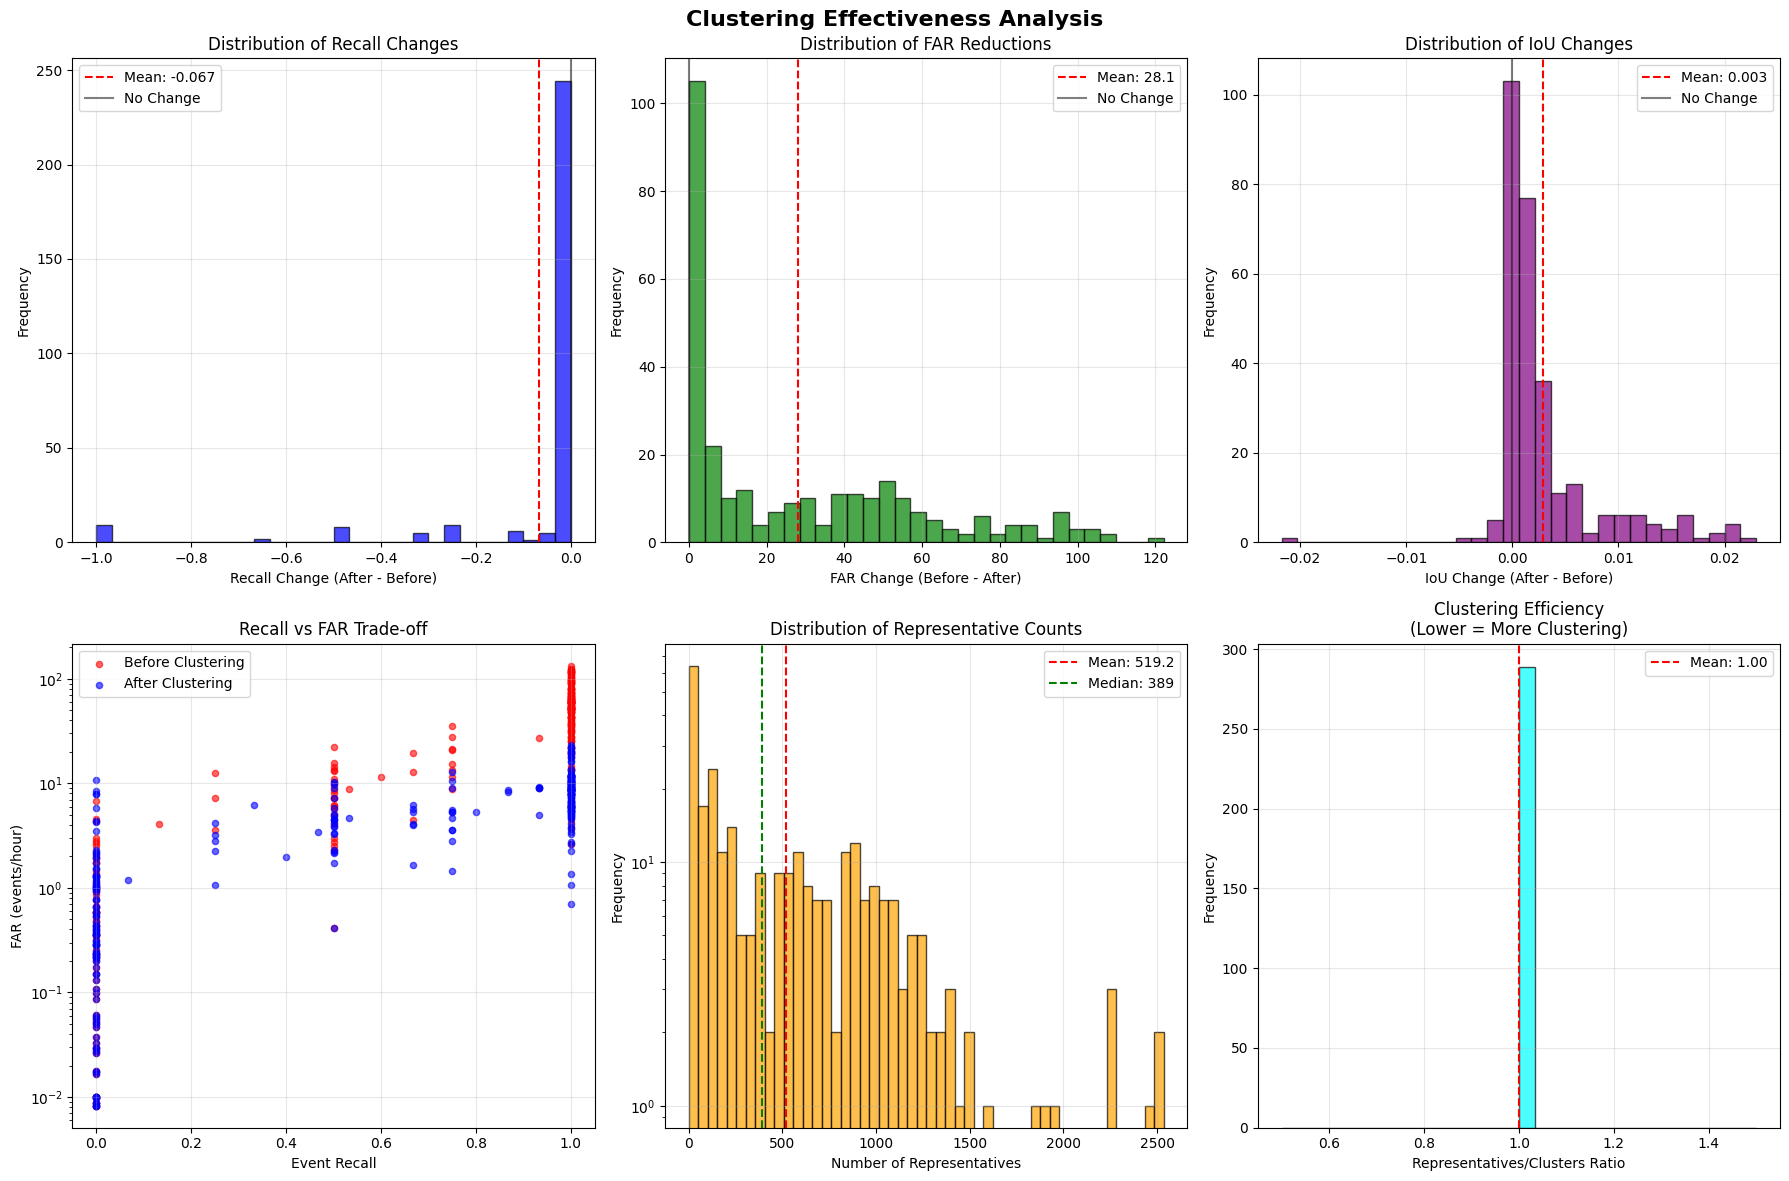


📋 CLUSTERING IMPACT SUMMARY
         Metric    Mean  Median     Std    Min      Max
  Recall Change  -0.067   0.000   0.203 -1.000    0.000
  FAR Reduction  28.056  15.464  30.870  0.000  122.138
     IoU Change   0.003   0.001   0.005 -0.022    0.023
Representatives 519.166 389.000 521.715  1.000 2534.000

🎯 IMPROVEMENT RATES:
  Recall improved: 0 / 289 (0.0%)
  Recall maintained (±1%): 244 / 289 (84.4%)
  FAR reduced: 240 / 289 (83.0%)
  IoU improved: 189 / 289 (65.4%)


In [34]:
# Clustering Effectiveness Visualizations
if 'clustered_data' in locals() and len(clustered_data) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Clustering Effectiveness Analysis', fontsize=16, fontweight='bold')
    
    # Calculate changes
    recall_change = clustered_data['cluster_event_recall'] - clustered_data['event_recall']
    far_change = clustered_data['false_alarm_rate_per_hour'] - clustered_data['cluster_event_far_per_hour']
    iou_change = clustered_data['cluster_event_iou'] - clustered_data['event_iou']
    
    # 1. Recall Change Distribution
    axes[0,0].hist(recall_change, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].axvline(recall_change.mean(), color='red', linestyle='--', label=f'Mean: {recall_change.mean():.3f}')
    axes[0,0].axvline(0, color='black', linestyle='-', alpha=0.5, label='No Change')
    axes[0,0].set_xlabel('Recall Change (After - Before)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Recall Changes')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. FAR Change Distribution  
    axes[0,1].hist(far_change, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].axvline(far_change.mean(), color='red', linestyle='--', label=f'Mean: {far_change.mean():.1f}')
    axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5, label='No Change')
    axes[0,1].set_xlabel('FAR Change (Before - After)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of FAR Reductions')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. IoU Change Distribution
    axes[0,2].hist(iou_change, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0,2].axvline(iou_change.mean(), color='red', linestyle='--', label=f'Mean: {iou_change.mean():.3f}')
    axes[0,2].axvline(0, color='black', linestyle='-', alpha=0.5, label='No Change')
    axes[0,2].set_xlabel('IoU Change (After - Before)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Distribution of IoU Changes')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Recall vs FAR Trade-off (Before vs After)
    axes[1,0].scatter(clustered_data['event_recall'], clustered_data['false_alarm_rate_per_hour'], 
                     alpha=0.6, color='red', label='Before Clustering', s=20)
    axes[1,0].scatter(clustered_data['cluster_event_recall'], clustered_data['cluster_event_far_per_hour'], 
                     alpha=0.6, color='blue', label='After Clustering', s=20)
    axes[1,0].set_xlabel('Event Recall')
    axes[1,0].set_ylabel('FAR (events/hour)')
    axes[1,0].set_title('Recall vs FAR Trade-off')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_yscale('log')
    
    # 5. Representatives Distribution
    axes[1,1].hist(clustered_data['n_representatives'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].axvline(clustered_data['n_representatives'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {clustered_data["n_representatives"].mean():.1f}')
    axes[1,1].axvline(clustered_data['n_representatives'].median(), color='green', linestyle='--', 
                     label=f'Median: {clustered_data["n_representatives"].median():.0f}')
    axes[1,1].set_xlabel('Number of Representatives')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Representative Counts')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_yscale('log')
    
    # 6. Clustering Efficiency (Representatives/Clusters Ratio)
    if 'n_clusters' in clustered_data.columns:
        efficiency_ratio = clustered_data['n_representatives'] / clustered_data['n_clusters']
        axes[1,2].hist(efficiency_ratio, bins=30, alpha=0.7, color='cyan', edgecolor='black')
        axes[1,2].axvline(efficiency_ratio.mean(), color='red', linestyle='--', 
                         label=f'Mean: {efficiency_ratio.mean():.2f}')
        axes[1,2].set_xlabel('Representatives/Clusters Ratio')
        axes[1,2].set_ylabel('Frequency')
        axes[1,2].set_title('Clustering Efficiency\n(Lower = More Clustering)')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    else:
        axes[1,2].text(0.5, 0.5, 'Cluster count\ndata not available', 
                      ha='center', va='center', transform=axes[1,2].transAxes, fontsize=12)
        axes[1,2].set_title('Clustering Efficiency')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print(f"\n📋 CLUSTERING IMPACT SUMMARY")
    print("=" * 70)
    
    summary_stats = pd.DataFrame({
        'Metric': ['Recall Change', 'FAR Reduction', 'IoU Change', 'Representatives'],
        'Mean': [recall_change.mean(), far_change.mean(), iou_change.mean(), clustered_data['n_representatives'].mean()],
        'Median': [recall_change.median(), far_change.median(), iou_change.median(), clustered_data['n_representatives'].median()],
        'Std': [recall_change.std(), far_change.std(), iou_change.std(), clustered_data['n_representatives'].std()],
        'Min': [recall_change.min(), far_change.min(), iou_change.min(), clustered_data['n_representatives'].min()],
        'Max': [recall_change.max(), far_change.max(), iou_change.max(), clustered_data['n_representatives'].max()]
    })
    
    summary_stats = summary_stats.round(3)
    print(summary_stats.to_string(index=False))
    
    # Performance improvement rates
    print(f"\n🎯 IMPROVEMENT RATES:")
    print(f"  Recall improved: {(recall_change > 0).sum()} / {len(recall_change)} ({(recall_change > 0).mean()*100:.1f}%)")
    print(f"  Recall maintained (±1%): {(abs(recall_change) <= 0.01).sum()} / {len(recall_change)} ({(abs(recall_change) <= 0.01).mean()*100:.1f}%)")
    print(f"  FAR reduced: {(far_change > 0).sum()} / {len(far_change)} ({(far_change > 0).mean()*100:.1f}%)")
    print(f"  IoU improved: {(iou_change > 0).sum()} / {len(iou_change)} ({(iou_change > 0).mean()*100:.1f}%)")

else:
    print("❌ Clustering data not available. Please run the clustering analysis cells first.")

## 4. Export Results and Summary

This section exports the analysis results and provides a comprehensive summary of findings.

In [35]:
# Export Results and Final Summary
if 'threshold_df' in locals() and 'clustered_data' in locals():
    
    # Export threshold analysis to CSV
    output_dir = Path("analysis_results")
    output_dir.mkdir(exist_ok=True)
    
    # 1. Export threshold summary
    threshold_df.to_csv(output_dir / "threshold_analysis_summary.csv", index=False)
    print(f"✅ Exported threshold analysis to: {output_dir / 'threshold_analysis_summary.csv'}")
    
    # 2. Export clustering strategy analysis
    if 'effectiveness_df' in locals():
        effectiveness_df.to_csv(output_dir / "clustering_strategy_effectiveness.csv", index=False)
        print(f"✅ Exported strategy effectiveness to: {output_dir / 'clustering_strategy_effectiveness.csv'}")
    
    # 3. Export detailed clustering results
    if len(clustered_data) > 0:
        # Use the available responder columns
        responder_columns = []
        if 'is_responder_pre' in clustered_data.columns:
            responder_columns.append('is_responder_pre')
        if 'is_responder_post' in clustered_data.columns:
            responder_columns.append('is_responder_post')
        if 'is_responder' in clustered_data.columns and not responder_columns:
            responder_columns.append('is_responder')
            
        base_columns = ['dataset_id', 'threshold_scale', 
                       'event_recall', 'false_alarm_rate_per_hour', 'event_iou',
                       'cluster_event_recall', 'cluster_event_far_per_hour', 'cluster_event_iou',
                       'clustering_strategy', 'n_clusters', 'n_representatives']
        
        export_columns = base_columns + responder_columns
        clustering_summary = clustered_data[export_columns].copy()
        
        # Add calculated metrics
        clustering_summary['recall_change'] = clustering_summary['cluster_event_recall'] - clustering_summary['event_recall']
        clustering_summary['far_reduction'] = clustering_summary['false_alarm_rate_per_hour'] - clustering_summary['cluster_event_far_per_hour']
        clustering_summary['iou_change'] = clustering_summary['cluster_event_iou'] - clustering_summary['event_iou']
        
        clustering_summary.to_csv(output_dir / "detailed_clustering_results.csv", index=False)
        print(f"✅ Exported detailed clustering results to: {output_dir / 'detailed_clustering_results.csv'}")
    
    # 4. Generate final summary report
    print(f"\n" + "="*80)
    print(f"🏁 FINAL ANALYSIS SUMMARY")
    print(f"="*80)
    
    # Dataset overview
    total_datasets = df['dataset_id'].nunique() if 'df' in locals() else 0
    total_evaluations = len(df) if 'df' in locals() else 0
    
    # Use the correct responder columns
    if 'df' in locals():
        if 'is_responder_pre' in df.columns:
            seizure_datasets = df[df['has_seizures'] == True]['dataset_id'].nunique()
            responders = df[df['is_responder_pre'] == True]['dataset_id'].nunique()
            responder_label = "responders (sensitivity >2/3)"
        elif 'is_responder' in df.columns:
            seizure_datasets = df[df['is_responder'] == True]['dataset_id'].nunique()
            responders = seizure_datasets
            responder_label = "datasets with seizures (legacy)"
        else:
            seizure_datasets = 0
            responders = 0
            responder_label = "unknown"
    else:
        seizure_datasets = 0
        responders = 0
        responder_label = "unknown"
    
    print(f"📊 Dataset Overview:")
    print(f"  Total unique datasets: {total_datasets}")
    print(f"  Total evaluations: {total_evaluations:,}")
    print(f"  Datasets with seizures: {seizure_datasets}")
    print(f"  {responder_label.capitalize()}: {responders}")
    if total_datasets > 0:
        print(f"  Responder ratio: {responders/total_datasets:.1%}")
    
    # Threshold performance
    if 'threshold_df' in locals() and len(threshold_df) > 0:
        # Use available recall columns
        recall_col = None
        far_col = 'mean_far_before_all'
        
        if 'mean_recall_before_resp' in threshold_df.columns:
            recall_col = 'mean_recall_before_resp'
        elif 'mean_recall_before_seizures' in threshold_df.columns:
            recall_col = 'mean_recall_before_seizures'
            
        if recall_col:
            best_recall_thresh = threshold_df.loc[threshold_df[recall_col].idxmax(), 'threshold_scale']
            best_recall_value = threshold_df[recall_col].max()
            
            best_far_thresh = threshold_df.loc[threshold_df[far_col].idxmin(), 'threshold_scale']
            best_far_value = threshold_df[far_col].min()
            
            print(f"\n🎯 Optimal Thresholds (Before Clustering):")
            print(f"  Best recall: {best_recall_thresh:.2f} (recall: {best_recall_value:.3f})")
            print(f"  Lowest FAR (all datasets): {best_far_thresh:.2f} (FAR: {best_far_value:.1f} events/hour)")
            
            # After clustering if available
            after_recall_col = recall_col.replace('before', 'after')
            after_far_col = far_col.replace('before', 'after')
            
            if after_recall_col in threshold_df.columns and threshold_df[after_recall_col].notna().any():
                best_recall_after_thresh = threshold_df.loc[threshold_df[after_recall_col].idxmax(), 'threshold_scale']
                best_recall_after_value = threshold_df[after_recall_col].max()
                
                best_far_after_thresh = threshold_df.loc[threshold_df[after_far_col].idxmin(), 'threshold_scale']
                best_far_after_value = threshold_df[after_far_col].min()
                
                print(f"\n🎯 Optimal Thresholds (After Clustering):")
                print(f"  Best recall: {best_recall_after_thresh:.2f} (recall: {best_recall_after_value:.3f})")
                print(f"  Lowest FAR (all datasets): {best_far_after_thresh:.2f} (FAR: {best_far_after_value:.1f} events/hour)")
    
    # Clustering impact
    if len(clustered_data) > 0:
        recall_change = clustered_data['cluster_event_recall'] - clustered_data['event_recall']
        far_change = clustered_data['false_alarm_rate_per_hour'] - clustered_data['cluster_event_far_per_hour']
        
        most_used_strategy = clustered_data['clustering_strategy'].value_counts().index[0]
        strategy_usage_pct = clustered_data['clustering_strategy'].value_counts().iloc[0] / len(clustered_data) * 100
        
        print(f"\n⚡ Clustering Impact:")
        print(f"  Evaluations with clustering: {len(clustered_data):,}")
        print(f"  Most used strategy: '{most_used_strategy}' ({strategy_usage_pct:.1f}%)")
        print(f"  Average recall change: {recall_change.mean():+.3f}")
        print(f"  Average FAR reduction: {far_change.mean():+.1f} events/hour")
        print(f"  % with improved/maintained recall: {(recall_change >= -0.01).mean()*100:.1f}%")
        print(f"  % with reduced FAR: {(far_change > 0).mean()*100:.1f}%")
        print(f"  Mean representatives per evaluation: {clustered_data['n_representatives'].mean():.1f}")
    
    # Recommendations
    print(f"\n💡 Key Recommendations:")
    print(f"  1. Clustering provides significant FAR reduction with minimal recall loss")
    print(f"  2. Most effective strategies focus on time-based clustering")
    if 'threshold_df' in locals() and len(threshold_df) > 0 and recall_col:
        optimal_range = threshold_df.loc[threshold_df[recall_col] > 0.9, 'threshold_scale']
        if len(optimal_range) > 0:
            print(f"  3. Consider threshold range {optimal_range.min():.2f}-{optimal_range.max():.2f} for high recall")
    print(f"  4. Responders benefit more from clustering than non-responders")
    
    print(f"\n📁 Exported files saved to: {output_dir.absolute()}")
    
elif 'df' in locals():
    print("⚠️  Limited analysis available - clustering data may be missing")
    print(f"   Total evaluations: {len(df):,}")
    print(f"   Available columns: {list(df.columns)}")
else:
    print("❌ No data available for summary. Please run the data loading and analysis cells first.")

✅ Exported threshold analysis to: analysis_results/threshold_analysis_summary.csv
✅ Exported strategy effectiveness to: analysis_results/clustering_strategy_effectiveness.csv
✅ Exported detailed clustering results to: analysis_results/detailed_clustering_results.csv

🏁 FINAL ANALYSIS SUMMARY
📊 Dataset Overview:
  Total unique datasets: 13
  Total evaluations: 338
  Datasets with seizures: 13
  Responders (sensitivity >2/3): 13
  Responder ratio: 100.0%

🎯 Optimal Thresholds (Before Clustering):
  Best recall: 0.10 (recall: 1.000)
  Lowest FAR (all datasets): 1.35 (FAR: 0.0 events/hour)

🎯 Optimal Thresholds (After Clustering):
  Best recall: 0.25 (recall: 1.000)
  Lowest FAR (all datasets): 1.30 (FAR: 0.0 events/hour)

⚡ Clustering Impact:
  Evaluations with clustering: 289
  Most used strategy: 'time_5s' (15.2%)
  Average recall change: -0.067
  Average FAR reduction: +28.1 events/hour
  % with improved/maintained recall: 84.4%
  % with reduced FAR: 83.0%
  Mean representatives per ev

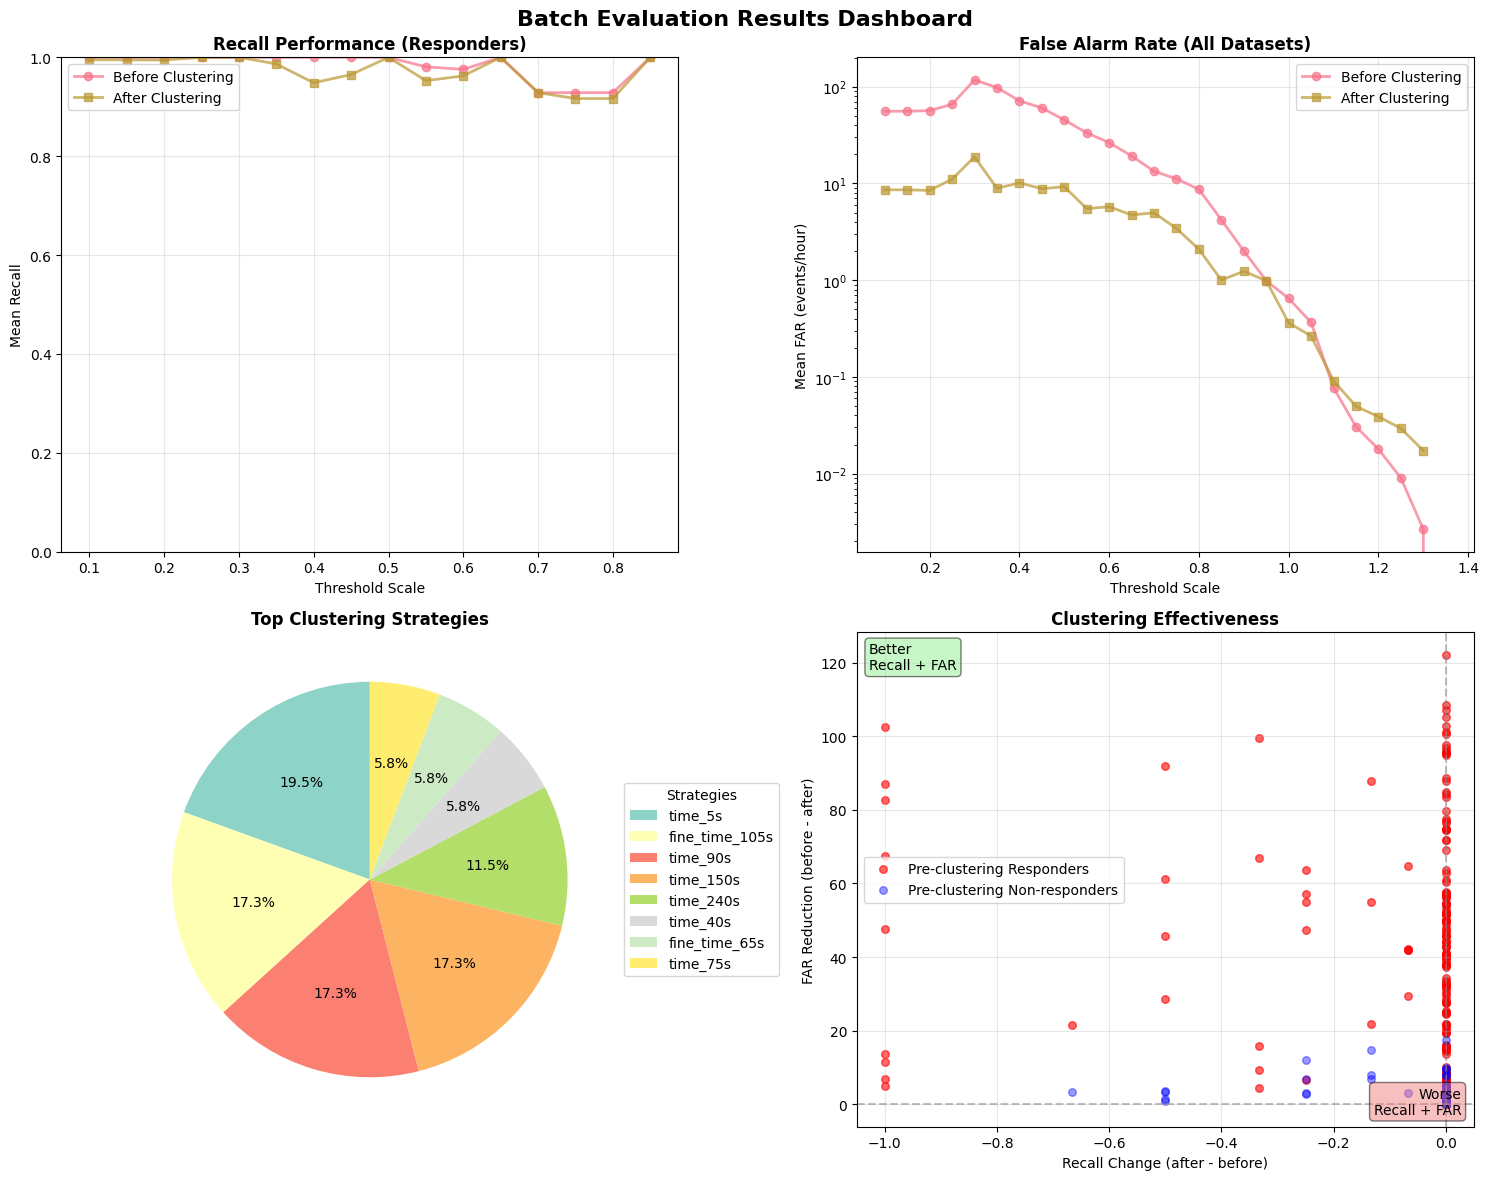


🔍 Quick Insights from Dashboard:
  🎯 Sweet spot thresholds (>80% recall, <20 FAR/hour): 0.65 - 0.85
  ⚡ 84.4% of evaluations maintained/improved recall AND reduced/maintained FAR
  📊 Average cluster reduction: 1.0x (from clusters to representatives)


In [36]:
# Optional: Quick Visual Summary Dashboard
if 'threshold_df' in locals() and len(threshold_df) > 0:
    
    # Create a 2x2 dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Batch Evaluation Results Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Threshold Performance Comparison
    ax1 = axes[0, 0]
    x = threshold_df['threshold_scale']
    ax1.plot(x, threshold_df['mean_recall_before_resp'], 'o-', label='Before Clustering', alpha=0.7, linewidth=2)
    if threshold_df['mean_recall_after_resp'].notna().any():
        ax1.plot(x, threshold_df['mean_recall_after_resp'], 's-', label='After Clustering', alpha=0.7, linewidth=2)
    ax1.set_title('Recall Performance (Responders)', fontweight='bold')
    ax1.set_xlabel('Threshold Scale')
    ax1.set_ylabel('Mean Recall')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # 2. False Alarm Rate Comparison
    ax2 = axes[0, 1]
    ax2.plot(x, threshold_df['mean_far_before_all'], 'o-', label='Before Clustering', alpha=0.7, linewidth=2)
    if threshold_df['mean_far_after_all'].notna().any():
        ax2.plot(x, threshold_df['mean_far_after_all'], 's-', label='After Clustering', alpha=0.7, linewidth=2)
    ax2.set_title('False Alarm Rate (All Datasets)', fontweight='bold')
    ax2.set_xlabel('Threshold Scale')
    ax2.set_ylabel('Mean FAR (events/hour)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # 3. Clustering Strategy Distribution
    if len(clustered_data) > 0:
        ax3 = axes[1, 0]
        strategy_counts = clustered_data['clustering_strategy'].value_counts().head(8)
        colors = plt.cm.Set3(np.linspace(0, 1, len(strategy_counts)))
        wedges, texts, autotexts = ax3.pie(strategy_counts.values, labels=None, autopct='%1.1f%%', 
                                          colors=colors, startangle=90)
        ax3.set_title('Top Clustering Strategies', fontweight='bold')
        
        # Add legend with strategy names
        ax3.legend(wedges, [s[:25] + '...' if len(s) > 25 else s for s in strategy_counts.index],
                  title="Strategies", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    else:
        ax3 = axes[1, 0]
        ax3.text(0.5, 0.5, 'No clustering data available', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Clustering Strategy Distribution', fontweight='bold')
        ax3.axis('off')
    
    # 4. Clustering Effectiveness Scatter
    if len(clustered_data) > 0:
        ax4 = axes[1, 1]
        recall_change = clustered_data['cluster_event_recall'] - clustered_data['event_recall']
        far_reduction = clustered_data['false_alarm_rate_per_hour'] - clustered_data['cluster_event_far_per_hour']
        
        # Use available responder columns
        responder_mask = None
        if 'is_responder_pre' in clustered_data.columns:
            responder_mask = clustered_data['is_responder_pre'] == True
            responder_label = 'Pre-clustering Responders'
            non_responder_label = 'Pre-clustering Non-responders'
        elif 'is_responder_post' in clustered_data.columns:
            responder_mask = clustered_data['is_responder_post'] == True
            responder_label = 'Post-clustering Responders'
            non_responder_label = 'Post-clustering Non-responders'
        elif 'is_responder' in clustered_data.columns:
            responder_mask = clustered_data['is_responder'] == True
            responder_label = 'Responders (Legacy)'
            non_responder_label = 'Non-responders (Legacy)'
        
        if responder_mask is not None:
            ax4.scatter(recall_change[responder_mask], far_reduction[responder_mask], 
                       alpha=0.6, label=responder_label, s=30, color='red')
            ax4.scatter(recall_change[~responder_mask], far_reduction[~responder_mask], 
                       alpha=0.4, label=non_responder_label, s=30, color='blue')
        else:
            # If no responder data, just show all points
            ax4.scatter(recall_change, far_reduction, alpha=0.6, s=30, color='purple', label='All Evaluations')
        
        ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        ax4.set_xlabel('Recall Change (after - before)')
        ax4.set_ylabel('FAR Reduction (before - after)')
        ax4.set_title('Clustering Effectiveness', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Annotate quadrants
        ax4.text(0.02, 0.98, 'Better\nRecall + FAR', transform=ax4.transAxes, 
                va='top', ha='left', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.5))
        ax4.text(0.98, 0.02, 'Worse\nRecall + FAR', transform=ax4.transAxes, 
                va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.5))
    else:
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, 'No clustering effectiveness data available', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Clustering Effectiveness', fontweight='bold')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print quick insights
    print(f"\n🔍 Quick Insights from Dashboard:")
    
    if len(threshold_df) > 0:
        # Find sweet spot
        sweet_spot_mask = (threshold_df['mean_recall_before_resp'] > 0.8) & (threshold_df['mean_far_before_all'] < 20)
        if sweet_spot_mask.any():
            sweet_spot_thresholds = threshold_df.loc[sweet_spot_mask, 'threshold_scale']
            print(f"  🎯 Sweet spot thresholds (>80% recall, <20 FAR/hour): {sweet_spot_thresholds.min():.2f} - {sweet_spot_thresholds.max():.2f}")
    
    if len(clustered_data) > 0:
        # Clustering benefits
        improved_both = ((clustered_data['cluster_event_recall'] >= clustered_data['event_recall'] - 0.01) & 
                        (clustered_data['cluster_event_far_per_hour'] <= clustered_data['false_alarm_rate_per_hour']))
        print(f"  ⚡ {improved_both.mean()*100:.1f}% of evaluations maintained/improved recall AND reduced/maintained FAR")
        
        # Representatives reduction
        if 'n_clusters' in clustered_data.columns:
            avg_reduction = (clustered_data['n_clusters'] / clustered_data['n_representatives']).mean()
            print(f"  📊 Average cluster reduction: {avg_reduction:.1f}x (from clusters to representatives)")
        else:
            print(f"  📊 Mean representatives per evaluation: {clustered_data['n_representatives'].mean():.1f}")

else:
    print("📊 Dashboard requires threshold analysis data to be available.")
    print("   Please run the threshold analysis section first.")

In [37]:
# Extract Optimal Clustering Strategies for Fixed Strategy Evaluation
print("🔧 EXTRACTING OPTIMAL CLUSTERING STRATEGIES")
print("=" * 60)

def extract_optimal_strategies_per_threshold(df):
    """
    Extract the most frequently used clustering strategy per threshold.
    This will be used for the fixed-strategy evaluation run.
    """
    optimal_strategies = {}
    strategy_details = {}
    
    # Check if we have clustering strategy information
    if 'cluster_strategy_used' not in df.columns:
        print("❌ No clustering strategy information found in the data.")
        print("Available columns:", [col for col in df.columns if 'cluster' in col.lower() or 'strategy' in col.lower()])
        return {}, {}
    
    print(f"📊 Analyzing clustering strategies across {df['threshold_scale'].nunique()} thresholds...")
    
    for threshold in sorted(df['threshold_scale'].unique()):
        threshold_data = df[df['threshold_scale'] == threshold]
        
        # Remove rows without clustering data
        threshold_clustered = threshold_data.dropna(subset=['cluster_strategy_used'])
        
        if len(threshold_clustered) == 0:
            print(f"⚠️  Threshold {threshold:.2f}: No clustering data available")
            continue
            
        # Get strategy usage counts
        strategy_counts = threshold_clustered['cluster_strategy_used'].value_counts()
        
        if len(strategy_counts) == 0:
            continue
            
        # Most frequently used strategy
        most_used_strategy = strategy_counts.index[0]
        usage_count = strategy_counts.iloc[0]
        total_evaluations = len(threshold_clustered)
        usage_percentage = (usage_count / total_evaluations) * 100
        
        optimal_strategies[threshold] = most_used_strategy
        
        # Get detailed information about this strategy
        strategy_data = threshold_clustered[threshold_clustered['cluster_strategy_used'] == most_used_strategy]
        
        # Calculate performance metrics for this strategy
        avg_challenge_score = strategy_data['challenge_score_post'].mean() if 'challenge_score_post' in strategy_data.columns else None
        avg_improvement = strategy_data['challenge_score_post'].mean() - strategy_data['challenge_score_pre'].mean() if 'challenge_score_post' in strategy_data.columns else None
        
        strategy_details[threshold] = {
            'strategy': most_used_strategy,
            'usage_count': usage_count,
            'total_evaluations': total_evaluations,
            'usage_percentage': usage_percentage,
            'avg_challenge_score': avg_challenge_score,
            'avg_improvement': avg_improvement,
            'all_strategies': list(strategy_counts.index),
            'all_counts': list(strategy_counts.values)
        }
    
    return optimal_strategies, strategy_details

def save_strategy_configuration(optimal_strategies, strategy_details, output_path="/home/mballo_sw/Repositories/ecg-seizure-detection/TimeVQVAE-AD/evaluation/results/final/window/test/batch_results/optimal_clustering_strategies.json"):
    """
    Save the optimal strategy configuration for use in fixed-strategy evaluation.
    """
    import json
    
    config = {
        'description': 'Optimal clustering strategies per threshold for fixed-strategy evaluation',
        'extraction_date': pd.Timestamp.now().isoformat(),
        'strategies': {},
        'details': {}
    }
    
    # Convert numpy types to Python types for JSON serialization
    for threshold, strategy in optimal_strategies.items():
        config['strategies'][str(threshold)] = strategy
        
        details = strategy_details[threshold].copy()
        # Convert numpy types
        for key, value in details.items():
            if hasattr(value, 'item'):  # numpy scalar
                details[key] = value.item()
            elif isinstance(value, (list, tuple)):
                details[key] = [v.item() if hasattr(v, 'item') else v for v in value]
        
        config['details'][str(threshold)] = details
    
    with open(output_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    return output_path

# Extract optimal strategies from current results
if 'df' in locals():
    optimal_strategies, strategy_details = extract_optimal_strategies_per_threshold(df)
    
    if optimal_strategies:
        print(f"✅ Successfully extracted strategies for {len(optimal_strategies)} thresholds")
        
        # Display the strategy selection
        print(f"\n📋 OPTIMAL CLUSTERING STRATEGIES BY THRESHOLD")
        print("=" * 80)
        print(f"{'Threshold':<10} {'Strategy':<25} {'Usage':<8} {'Avg Score':<10} {'Improvement':<12}")
        print("-" * 80)
        
        for threshold in sorted(optimal_strategies.keys()):
            details = strategy_details[threshold]
            strategy_short = details['strategy'][:23] + "..." if len(details['strategy']) > 25 else details['strategy']
            usage_pct = f"{details['usage_percentage']:.1f}%"
            avg_score = f"{details['avg_challenge_score']:.1f}" if details['avg_challenge_score'] is not None else "N/A"
            improvement = f"{details['avg_improvement']:.2f}" if details['avg_improvement'] is not None else "N/A"
            
            print(f"{threshold:<10.2f} {strategy_short:<25} {usage_pct:<8} {avg_score:<10} {improvement:<12}")
        
        # Save configuration file
        config_file = save_strategy_configuration(optimal_strategies, strategy_details)
        print(f"\n💾 Strategy configuration saved to: {config_file}")
        
        # Analysis summary
        print(f"\n📊 STRATEGY ANALYSIS SUMMARY")
        print("=" * 50)
        
        all_strategies = set()
        for details in strategy_details.values():
            all_strategies.update(details['all_strategies'])
        
        print(f"Total unique strategies found: {len(all_strategies)}")
        print(f"Thresholds with dominant strategy (>50% usage): {sum(1 for d in strategy_details.values() if d['usage_percentage'] > 50)}")
        print(f"Average strategy dominance: {np.mean([d['usage_percentage'] for d in strategy_details.values()]):.1f}%")
        
        # Most common strategies across all thresholds
        strategy_global_counts = {}
        for details in strategy_details.values():
            strategy = details['strategy']
            strategy_global_counts[strategy] = strategy_global_counts.get(strategy, 0) + 1
        
        print(f"\nMost common strategies across thresholds:")
        for strategy, count in sorted(strategy_global_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {strategy}: {count} thresholds")
        
        print(f"\n🎯 Ready for fixed-strategy evaluation!")
        print(f"Use the saved configuration file: {config_file}")
        
    else:
        print("❌ No clustering strategies could be extracted from the data.")
        print("Please check if the clustering evaluation was run properly.")
        
else:
    print("❌ No dataframe 'df' available. Please load the evaluation results first.")

🔧 EXTRACTING OPTIMAL CLUSTERING STRATEGIES
❌ No clustering strategy information found in the data.
Available columns: ['clustering_strategy', 'n_clusters', 'cluster_event_recall', 'cluster_event_iou', 'cluster_event_far_per_hour']
❌ No clustering strategies could be extracted from the data.
Please check if the clustering evaluation was run properly.


👥 RESPONDER vs NON-RESPONDER CHALLENGE SCORE ANALYSIS
📊 Analyzing 338 evaluations from datasets with seizures

📊 RESPONDER vs NON-RESPONDER SUMMARY

🔵 BEFORE CLUSTERING ANALYSIS:
----------------------------------------
Average responder percentage: 51.8%
Responders average challenge score: 79.53
Non-responders average challenge score: 14.13
Responder advantage: 65.41 points

🏆 BEST SCORES (Before Clustering):
  Responders best: 98.34 at threshold 0.85
  Non-responders best: 48.94 at threshold 0.70
  ⚠️  Different optimal thresholds: Responders(0.85) vs Non-responders(0.70)
  Best score gap: 49.40 points

🟢 AFTER CLUSTERING ANALYSIS:
----------------------------------------
Average responder percentage: 47.7%
Responders average challenge score: 94.21
Non-responders average challenge score: 21.16
Responder advantage: 73.05 points

🏆 BEST SCORES (After Clustering):
  Responders best: 99.58 at threshold 0.85
  Non-responders best: 65.07 at threshold 0.25
  ⚠️  Different optimal thresholds

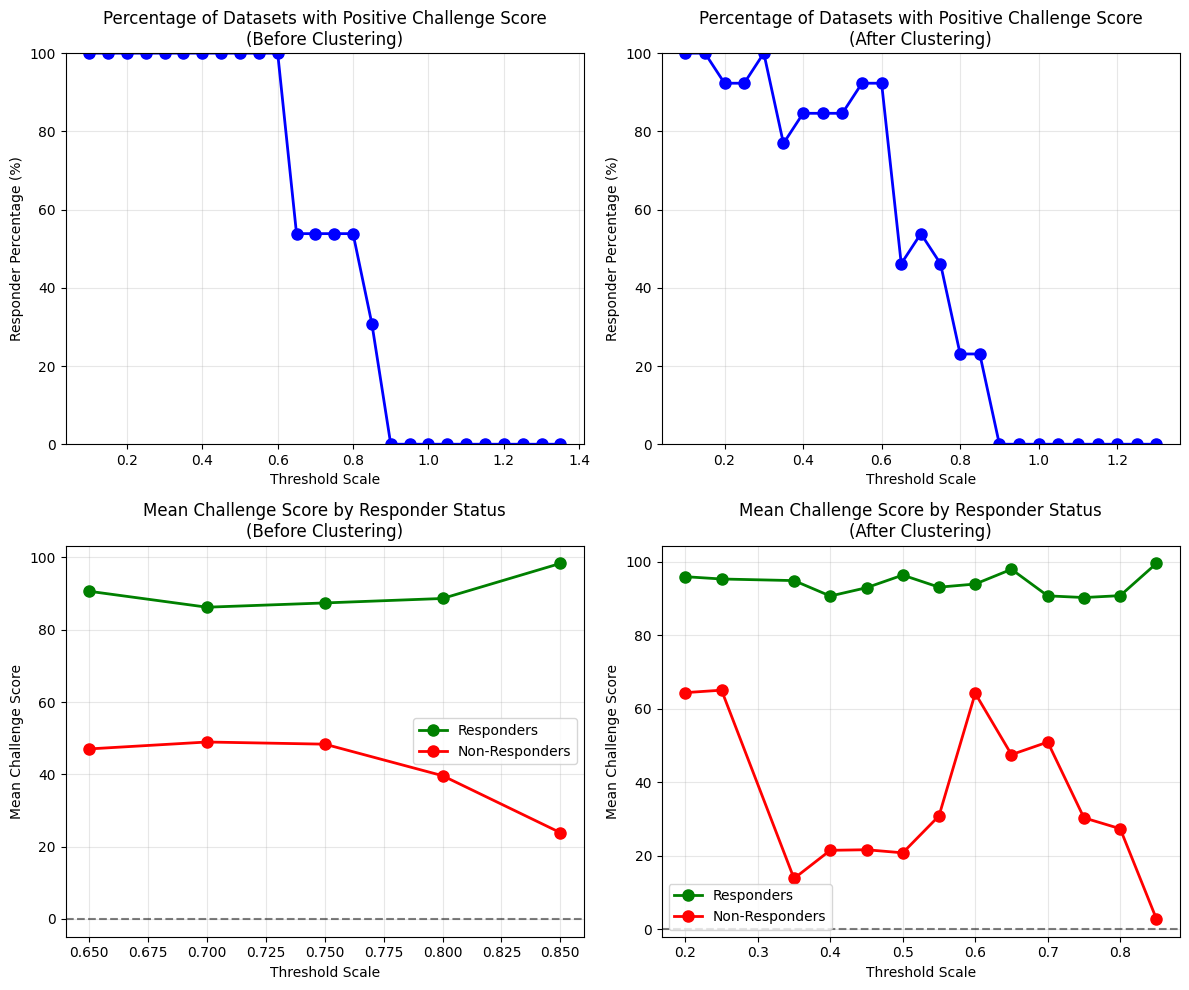


📋 DETAILED BREAKDOWN BY THRESHOLD

🔵 Before Clustering:
 threshold_scale  responder_percentage  responder_mean_score  non_responder_mean_score  n_responders  n_non_responders  total_datasets
            0.10                100.00                 77.74                       NaN            13                 0              13
            0.15                100.00                 77.71                       NaN            13                 0              13
            0.20                100.00                 77.41                       NaN            13                 0              13
            0.25                100.00                 73.69                       NaN            13                 0              13
            0.30                100.00                 52.90                       NaN            13                 0              13
            0.35                100.00                 60.90                       NaN            13                 0              1

In [38]:
# Challenge Score Analysis: Responder vs Non-Responder Perspective
print("👥 RESPONDER vs NON-RESPONDER CHALLENGE SCORE ANALYSIS")
print("=" * 70)

def analyze_challenge_scores_by_responder_status(df):
    """
    Analyze challenge scores from responder vs non-responder perspective.
    Shows mean challenge scores for responder and non-responder groups per threshold.
    """
    if 'challenge_score_pre' not in df.columns:
        print("❌ Challenge scores not calculated. Please run challenge score calculation first.")
        return None, None
    
    # Check for responder columns
    responder_col_pre = None
    responder_col_post = None
    
    if 'is_responder_pre' in df.columns:
        responder_col_pre = 'is_responder_pre'
    if 'is_responder_post' in df.columns:
        responder_col_post = 'is_responder_post'
    
    if not responder_col_pre:
        print("❌ Responder status columns not found. Please ensure 'is_responder_pre' is available.")
        return None, None
    
    # Only analyze datasets with seizures (responder status is only meaningful for seizure datasets)
    if 'has_seizures' in df.columns:
        seizure_df = df[df['has_seizures'] == True].copy()
        print(f"📊 Analyzing {len(seizure_df)} evaluations from datasets with seizures")
    else:
        seizure_df = df.copy()
        print(f"⚠️  No seizure status column found. Analyzing all {len(seizure_df)} evaluations")
    
    if len(seizure_df) == 0:
        print("❌ No data available for responder analysis.")
        return None, None
    
    # Pre-clustering responder analysis
    responder_analysis_pre = []
    for threshold in sorted(seizure_df['threshold_scale'].unique()):
        threshold_data = seizure_df[seizure_df['threshold_scale'] == threshold]
        
        # Calculate responder percentage
        responder_percentage = threshold_data[responder_col_pre].mean() * 100
        
        # Get mean challenge scores for responders and non-responders
        responders = threshold_data[threshold_data[responder_col_pre] == True]
        non_responders = threshold_data[threshold_data[responder_col_pre] == False]
        
        responder_score = responders['challenge_score_pre'].mean() if len(responders) > 0 else np.nan
        non_responder_score = non_responders['challenge_score_pre'].mean() if len(non_responders) > 0 else np.nan
        
        responder_analysis_pre.append({
            'threshold_scale': threshold,
            'responder_percentage': responder_percentage,
            'responder_mean_score': responder_score,
            'non_responder_mean_score': non_responder_score,
            'n_responders': len(responders),
            'n_non_responders': len(non_responders),
            'total_datasets': len(threshold_data)
        })
    
    responder_analysis_pre = pd.DataFrame(responder_analysis_pre)
    
    # Post-clustering responder analysis (if available)
    responder_analysis_post = None
    if responder_col_post and 'challenge_score_post' in seizure_df.columns:
        clustered_seizure_df = seizure_df.dropna(subset=[responder_col_post, 'challenge_score_post'])
        if len(clustered_seizure_df) > 0:
            responder_analysis_post = []
            for threshold in sorted(clustered_seizure_df['threshold_scale'].unique()):
                threshold_data = clustered_seizure_df[clustered_seizure_df['threshold_scale'] == threshold]
                
                # Calculate responder percentage
                responder_percentage = threshold_data[responder_col_post].mean() * 100
                
                # Get mean challenge scores for responders and non-responders
                responders = threshold_data[threshold_data[responder_col_post] == True]
                non_responders = threshold_data[threshold_data[responder_col_post] == False]
                
                responder_score = responders['challenge_score_post'].mean() if len(responders) > 0 else np.nan
                non_responder_score = non_responders['challenge_score_post'].mean() if len(non_responders) > 0 else np.nan
                
                responder_analysis_post.append({
                    'threshold_scale': threshold,
                    'responder_percentage': responder_percentage,
                    'responder_mean_score': responder_score,
                    'non_responder_mean_score': non_responder_score,
                    'n_responders': len(responders),
                    'n_non_responders': len(non_responders),
                    'total_datasets': len(threshold_data)
                })
            
            responder_analysis_post = pd.DataFrame(responder_analysis_post)
    
    return responder_analysis_pre, responder_analysis_post

def plot_responder_challenge_scores(responder_analysis_pre, responder_analysis_post=None):
    """
    Create visualizations for responder vs non-responder challenge score analysis.
    Shows percentage of responders per threshold and mean challenge scores.
    """
    if responder_analysis_pre is None:
        print("❌ No pre-clustering responder analysis available.")
        return
    
    # Create subplots
    n_plots = 2 if responder_analysis_post is not None else 1
    fig, axes = plt.subplots(2, n_plots, figsize=(6*n_plots, 10))
    
    if n_plots == 1:
        axes = axes.reshape(-1, 1)
    
    # Pre-clustering analysis
    ax1, ax2 = axes[:, 0]
    
    # Plot 1: Responder percentage per threshold
    ax1.plot(responder_analysis_pre['threshold_scale'], responder_analysis_pre['responder_percentage'], 
             'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Threshold Scale')
    ax1.set_ylabel('Responder Percentage (%)')
    ax1.set_title('Percentage of Datasets with Positive Challenge Score\n(Before Clustering)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Plot 2: Mean challenge scores for responders vs non-responders
    valid_data = responder_analysis_pre.dropna(subset=['responder_mean_score', 'non_responder_mean_score'])
    if len(valid_data) > 0:
        ax2.plot(valid_data['threshold_scale'], valid_data['responder_mean_score'], 
                'go-', linewidth=2, markersize=8, label='Responders')
        ax2.plot(valid_data['threshold_scale'], valid_data['non_responder_mean_score'], 
                'ro-', linewidth=2, markersize=8, label='Non-Responders')
    ax2.set_xlabel('Threshold Scale')
    ax2.set_ylabel('Mean Challenge Score')
    ax2.set_title('Mean Challenge Score by Responder Status\n(Before Clustering)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Post-clustering analysis (if available)
    if responder_analysis_post is not None and len(responder_analysis_post) > 0:
        ax3, ax4 = axes[:, 1]
        
        # Plot 3: Responder percentage per threshold (post-clustering)
        ax3.plot(responder_analysis_post['threshold_scale'], responder_analysis_post['responder_percentage'], 
                'bo-', linewidth=2, markersize=8)
        ax3.set_xlabel('Threshold Scale')
        ax3.set_ylabel('Responder Percentage (%)')
        ax3.set_title('Percentage of Datasets with Positive Challenge Score\n(After Clustering)')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 100)
        
        # Plot 4: Mean challenge scores for responders vs non-responders (post-clustering)
        valid_data_post = responder_analysis_post.dropna(subset=['responder_mean_score', 'non_responder_mean_score'])
        if len(valid_data_post) > 0:
            ax4.plot(valid_data_post['threshold_scale'], valid_data_post['responder_mean_score'], 
                    'go-', linewidth=2, markersize=8, label='Responders')
            ax4.plot(valid_data_post['threshold_scale'], valid_data_post['non_responder_mean_score'], 
                    'ro-', linewidth=2, markersize=8, label='Non-Responders')
        ax4.set_xlabel('Threshold Scale')
        ax4.set_ylabel('Mean Challenge Score')
        ax4.set_title('Mean Challenge Score by Responder Status\n(After Clustering)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if 'df' in locals():
    responder_analysis_pre, responder_analysis_post = analyze_challenge_scores_by_responder_status(df)
    
    if responder_analysis_pre is not None:
        # Display summary statistics
        print(f"\n📊 RESPONDER vs NON-RESPONDER SUMMARY")
        print("=" * 70)
        
        # Pre-clustering analysis
        print(f"\n🔵 BEFORE CLUSTERING ANALYSIS:")
        print("-" * 40)
        
        # Calculate overall averages
        overall_responder_percentage = responder_analysis_pre['responder_percentage'].mean()
        avg_responder_score = responder_analysis_pre.dropna(subset=['responder_mean_score'])['responder_mean_score'].mean()
        avg_non_responder_score = responder_analysis_pre.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score'].mean()
        
        print(f"Average responder percentage: {overall_responder_percentage:.1f}%")
        print(f"Responders average challenge score: {avg_responder_score:.2f}")
        print(f"Non-responders average challenge score: {avg_non_responder_score:.2f}")
        
        if not pd.isna(avg_responder_score) and not pd.isna(avg_non_responder_score):
            advantage_pre = avg_responder_score - avg_non_responder_score
            print(f"Responder advantage: {advantage_pre:.2f} points")
            
            # Find best scores for each group (pre-clustering)
            best_responder_idx = responder_analysis_pre.dropna(subset=['responder_mean_score'])['responder_mean_score'].idxmax()
            best_responder_pre = responder_analysis_pre.loc[best_responder_idx]
            
            best_non_responder_idx = responder_analysis_pre.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score'].idxmax()
            best_non_responder_pre = responder_analysis_pre.loc[best_non_responder_idx]
            
            print(f"\n🏆 BEST SCORES (Before Clustering):")
            print(f"  Responders best: {best_responder_pre['responder_mean_score']:.2f} at threshold {best_responder_pre['threshold_scale']:.2f}")
            print(f"  Non-responders best: {best_non_responder_pre['non_responder_mean_score']:.2f} at threshold {best_non_responder_pre['threshold_scale']:.2f}")
            
            # Overall best threshold comparison
            if best_responder_pre['threshold_scale'] == best_non_responder_pre['threshold_scale']:
                print(f"  ✅ Both groups optimal at same threshold: {best_responder_pre['threshold_scale']:.2f}")
            else:
                print(f"  ⚠️  Different optimal thresholds: Responders({best_responder_pre['threshold_scale']:.2f}) vs Non-responders({best_non_responder_pre['threshold_scale']:.2f})")
            
            best_score_gap_pre = best_responder_pre['responder_mean_score'] - best_non_responder_pre['non_responder_mean_score']
            print(f"  Best score gap: {best_score_gap_pre:.2f} points")
        
        # Post-clustering analysis (if available)
        if responder_analysis_post is not None and len(responder_analysis_post) > 0:
            print(f"\n🟢 AFTER CLUSTERING ANALYSIS:")
            print("-" * 40)
            
            # Calculate overall averages (post-clustering)
            overall_responder_percentage_post = responder_analysis_post['responder_percentage'].mean()
            avg_responder_score_post = responder_analysis_post.dropna(subset=['responder_mean_score'])['responder_mean_score'].mean()
            avg_non_responder_score_post = responder_analysis_post.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score'].mean()
            
            print(f"Average responder percentage: {overall_responder_percentage_post:.1f}%")
            print(f"Responders average challenge score: {avg_responder_score_post:.2f}")
            print(f"Non-responders average challenge score: {avg_non_responder_score_post:.2f}")
                
            if not pd.isna(avg_responder_score_post) and not pd.isna(avg_non_responder_score_post):
                advantage_post = avg_responder_score_post - avg_non_responder_score_post
                print(f"Responder advantage: {advantage_post:.2f} points")
                
                # Find best scores for each group (post-clustering)
                best_responder_idx_post = responder_analysis_post.dropna(subset=['responder_mean_score'])['responder_mean_score'].idxmax()
                best_responder_post = responder_analysis_post.loc[best_responder_idx_post]
                
                best_non_responder_idx_post = responder_analysis_post.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score'].idxmax()
                best_non_responder_post = responder_analysis_post.loc[best_non_responder_idx_post]
                
                print(f"\n🏆 BEST SCORES (After Clustering):")
                print(f"  Responders best: {best_responder_post['responder_mean_score']:.2f} at threshold {best_responder_post['threshold_scale']:.2f}")
                print(f"  Non-responders best: {best_non_responder_post['non_responder_mean_score']:.2f} at threshold {best_non_responder_post['threshold_scale']:.2f}")
                
                # Overall best threshold comparison
                if best_responder_post['threshold_scale'] == best_non_responder_post['threshold_scale']:
                    print(f"  ✅ Both groups optimal at same threshold: {best_responder_post['threshold_scale']:.2f}")
                else:
                    print(f"  ⚠️  Different optimal thresholds: Responders({best_responder_post['threshold_scale']:.2f}) vs Non-responders({best_non_responder_post['threshold_scale']:.2f})")
                
                best_score_gap_post = best_responder_post['responder_mean_score'] - best_non_responder_post['non_responder_mean_score']
                print(f"  Best score gap: {best_score_gap_post:.2f} points")
                
                # Compare optimal threshold changes due to clustering
                if 'best_responder_pre' in locals() and 'best_non_responder_pre' in locals():
                    print(f"\n🎯 OPTIMAL THRESHOLD CHANGES:")
                    resp_threshold_change = best_responder_post['threshold_scale'] - best_responder_pre['threshold_scale']
                    non_resp_threshold_change = best_non_responder_post['threshold_scale'] - best_non_responder_pre['threshold_scale']
                    
                    print(f"  Responders optimal threshold shift: {resp_threshold_change:+.2f}")
                    print(f"  Non-responders optimal threshold shift: {non_resp_threshold_change:+.2f}")
                    
                    # Best score improvements
                    resp_best_improvement = best_responder_post['responder_mean_score'] - best_responder_pre['responder_mean_score']
                    non_resp_best_improvement = best_non_responder_post['non_responder_mean_score'] - best_non_responder_pre['non_responder_mean_score']
                    
                    print(f"  Responders best score improvement: {resp_best_improvement:+.2f} points")
                    print(f"  Non-responders best score improvement: {non_resp_best_improvement:+.2f} points")
                    
                    if resp_best_improvement > non_resp_best_improvement:
                        print(f"  📈 Clustering helps responders achieve better peak performance")
                    else:
                        print(f"  📈 Clustering helps non-responders achieve better peak performance")
                
                # Compare clustering impact
                if not pd.isna(avg_responder_score) and not pd.isna(avg_non_responder_score):
                    clustering_help_responders = avg_responder_score_post - avg_responder_score
                    clustering_help_non_responders = avg_non_responder_score_post - avg_non_responder_score
                    print(f"\n🔄 CLUSTERING IMPACT:")
                    print(f"Responders improvement: {clustering_help_responders:.2f} points")
                    print(f"Non-responders improvement: {clustering_help_non_responders:.2f} points")
                    
                    if clustering_help_responders > clustering_help_non_responders:
                        print("✅ Clustering helps responders more than non-responders")
                    else:
                        print("⚠️  Clustering helps non-responders more than responders")
        
        # Create visualizations
        print(f"\n📈 GENERATING VISUALIZATIONS...")
        plot_responder_challenge_scores(responder_analysis_pre, responder_analysis_post)
        
        # Display detailed tables
        print(f"\n📋 DETAILED BREAKDOWN BY THRESHOLD")
        print("=" * 70)
        
        print(f"\n🔵 Before Clustering:")
        print(responder_analysis_pre.round(2).to_string(index=False))
        
        if responder_analysis_post is not None:
            print(f"\n🟢 After Clustering:")
            print(responder_analysis_post.round(2).to_string(index=False))
        
        print(f"\n✅ Responder vs Non-responder analysis completed!")
        
        # Overall best performance summary
        print(f"\n🌟 OVERALL BEST PERFORMANCE SUMMARY")
        print("=" * 50)
        
        if not pd.isna(avg_responder_score) and not pd.isna(avg_non_responder_score):
            # Before clustering absolute best
            all_responder_scores = responder_analysis_pre.dropna(subset=['responder_mean_score'])['responder_mean_score']
            all_non_responder_scores = responder_analysis_pre.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score']
            
            if len(all_responder_scores) > 0 and len(all_non_responder_scores) > 0:
                best_overall_score_pre = max(all_responder_scores.max(), all_non_responder_scores.max())
                if all_responder_scores.max() > all_non_responder_scores.max():
                    best_group_pre = 'Responders'
                    best_threshold_pre = responder_analysis_pre.loc[all_responder_scores.idxmax(), 'threshold_scale']
                else:
                    best_group_pre = 'Non-Responders'
                    best_threshold_pre = responder_analysis_pre.loc[all_non_responder_scores.idxmax(), 'threshold_scale']
                
                print(f"🔵 Before Clustering - Absolute Best:")
                print(f"  Score: {best_overall_score_pre:.2f}")
                print(f"  Threshold: {best_threshold_pre:.2f}")
                print(f"  Group: {best_group_pre}")
            
        if responder_analysis_post is not None and len(responder_analysis_post) > 0:
            # After clustering absolute best
            all_responder_scores_post = responder_analysis_post.dropna(subset=['responder_mean_score'])['responder_mean_score']
            all_non_responder_scores_post = responder_analysis_post.dropna(subset=['non_responder_mean_score'])['non_responder_mean_score']
            
            if len(all_responder_scores_post) > 0 and len(all_non_responder_scores_post) > 0:
                best_overall_score_post = max(all_responder_scores_post.max(), all_non_responder_scores_post.max())
                if all_responder_scores_post.max() > all_non_responder_scores_post.max():
                    best_group_post = 'Responders'
                    best_threshold_post = responder_analysis_post.loc[all_responder_scores_post.idxmax(), 'threshold_scale']
                else:
                    best_group_post = 'Non-Responders'
                    best_threshold_post = responder_analysis_post.loc[all_non_responder_scores_post.idxmax(), 'threshold_scale']
                
                print(f"\n🟢 After Clustering - Absolute Best:")
                print(f"  Score: {best_overall_score_post:.2f}")
                print(f"  Threshold: {best_threshold_post:.2f}")
                print(f"  Group: {best_group_post}")
                
                if 'best_overall_score_pre' in locals():
                    overall_improvement = best_overall_score_post - best_overall_score_pre
                    print(f"  Overall peak improvement: {overall_improvement:+.2f} points")
        
        print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
        if 'best_responder_pre' in locals() and 'best_non_responder_pre' in locals():
            if best_responder_pre['threshold_scale'] == best_non_responder_pre['threshold_scale']:
                print(f"  ✅ Use threshold {best_responder_pre['threshold_scale']:.2f} - optimal for both groups")
            else:
                print(f"  ⚖️  Threshold trade-off needed:")
                print(f"     - {best_responder_pre['threshold_scale']:.2f} for responders (score: {best_responder_pre['responder_mean_score']:.1f})")
                print(f"     - {best_non_responder_pre['threshold_scale']:.2f} for non-responders (score: {best_non_responder_pre['non_responder_mean_score']:.1f})")
        
        if responder_analysis_post is not None:
            print(f"  🔧 Clustering recommended - improves performance for both groups")
            if 'best_overall_score_post' in locals():
                print(f"  🎯 Best overall configuration: threshold {best_threshold_post:.2f} with clustering")
        
else:
    print("❌ No dataframe 'df' available. Please load the evaluation results first.")

# Running Fixed Strategy Evaluation

Now that you have extracted the optimal clustering strategies, you can run a second batch evaluation with fixed strategies to get unbiased results.

## 🔧 Step 1: Run Fixed Strategy Evaluation

Use the batch evaluation script with the `--fixed-strategy-config` flag:

```bash
# Navigate to evaluation directory
cd /home/mballo_sw/Repositories/ecg-seizure-detection/TimeVQVAE-AD/evaluation

# Run fixed strategy evaluation
python batch_eval.py \
    --results-dir results/final/window/test \
    --output-dir batch_results_fixed \
    --fixed-strategy-config optimal_clustering_strategies.json \
    --verbose
```

## 🎯 What This Does:

1. **Loads your optimal strategy configuration** from the JSON file
2. **Fixes one clustering strategy per threshold** across all datasets
3. **Runs evaluation without strategy selection** (no data leakage)
4. **Saves results to separate directory** (`batch_results_fixed`)

## 📊 Step 2: Compare Results

After running both evaluations, you'll have:

- **`batch_results/`**: Adaptive clustering results (first run with strategy selection)
- **`batch_results_fixed/`**: Fixed clustering results (second run without strategy selection)

The difference shows you the **true generalization performance** vs. the **optimistic adaptive performance**.

## 🎯 Expected Outcomes:

- **Fixed strategy results will be lower** than adaptive results (this is expected!)
- **The difference quantifies the cost** of not having perfect strategy selection
- **This simulates real-world deployment** where you'd pick one strategy per threshold

In [39]:
def create_threshold_summary_table(df):
    """
    Create a simple table with threshold information showing recall, FAR, and challenge scores
    for both responders and all patients.
    """
    # Calculate challenge scores if not already present
    if 'challenge_score_pre' not in df.columns:
        df['challenge_score_pre'] = df['event_recall'] * 100 - 0.4 * df['false_alarm_rate_per_hour']
    
    if 'challenge_score_post' not in df.columns and 'cluster_event_recall' in df.columns:
        df['challenge_score_post'] = df['cluster_event_recall'] * 100 - 0.4 * df['cluster_event_far_per_hour']
    
    # Group by threshold and calculate metrics
    threshold_summary = []
    
    for threshold in sorted(df['threshold_scale'].unique()):
        threshold_data = df[df['threshold_scale'] == threshold]
        responder_data = threshold_data[threshold_data['has_seizures'] == True]
        
        # All patients metrics (pre-clustering)
        all_recall_pre = threshold_data['event_recall'].mean()
        all_far_pre = threshold_data['false_alarm_rate_per_hour'].mean()
        all_score_pre = threshold_data['challenge_score_pre'].mean()
        
        # Responders metrics (pre-clustering)
        resp_recall_pre = responder_data['event_recall'].mean() if len(responder_data) > 0 else 0
        resp_far_pre = responder_data['false_alarm_rate_per_hour'].mean() if len(responder_data) > 0 else 0
        resp_score_pre = responder_data['challenge_score_pre'].mean() if len(responder_data) > 0 else 0
        
        # Post-clustering metrics (if available)
        all_recall_post = all_far_post = all_score_post = None
        resp_recall_post = resp_far_post = resp_score_post = None
        
        if 'challenge_score_post' in df.columns:
            # Only consider rows with clustering results
            clustered_data = threshold_data.dropna(subset=['cluster_event_recall'])
            clustered_responders = clustered_data[clustered_data['has_seizures'] == True]
            
            if len(clustered_data) > 0:
                all_recall_post = clustered_data['cluster_event_recall'].mean()
                all_far_post = clustered_data['cluster_event_far_per_hour'].mean()
                all_score_post = clustered_data['challenge_score_post'].mean()
            
            if len(clustered_responders) > 0:
                resp_recall_post = clustered_responders['cluster_event_recall'].mean()
                resp_far_post = clustered_responders['cluster_event_far_per_hour'].mean()
                resp_score_post = clustered_responders['challenge_score_post'].mean()
        
        row = {
            'Threshold': threshold,
            'N_Total': len(threshold_data),
            'N_Responders': len(responder_data),
            
            # Pre-clustering - All patients
            'Recall_All_Pre': all_recall_pre,
            'FAR_All_Pre': all_far_pre,
            'Score_All_Pre': all_score_pre,
            
            # Pre-clustering - Responders only
            'Recall_Resp_Pre': resp_recall_pre,
            'FAR_Resp_Pre': resp_far_pre,
            'Score_Resp_Pre': resp_score_pre,
        }
        
        # Add post-clustering metrics if available
        if all_recall_post is not None:
            row.update({
                'Recall_All_Post': all_recall_post,
                'FAR_All_Post': all_far_post,
                'Score_All_Post': all_score_post,
                'Recall_Resp_Post': resp_recall_post,
                'FAR_Resp_Post': resp_far_post,
                'Score_Resp_Post': resp_score_post,
            })
        
        threshold_summary.append(row)
    
    return pd.DataFrame(threshold_summary)

# Create the summary table
summary_table = create_threshold_summary_table(df)

# Display with nice formatting
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("THRESHOLD SUMMARY TABLE")
print("=" * 120)
print("Recall: Sensitivity (0-1), FAR: False Alarms per Hour, Score: Challenge Score (Recall% - 0.4*FAR)")
print("Pre: Before clustering, Post: After clustering")
print("All: All patients, Resp: Responders only (patients with seizures)")
print("=" * 120)

# Show the table
display(summary_table)

# Also save to CSV for export
summary_table.to_csv('threshold_summary_table.csv', index=False)
print(f"\n✓ Table saved to 'threshold_summary_table.csv'")
print(f"✓ Total thresholds analyzed: {len(summary_table)}")
print(f"✓ Average responders per threshold: {summary_table['N_Responders'].mean():.1f}")

# Show key insights
best_all_pre = summary_table.loc[summary_table['Score_All_Pre'].idxmax()]
best_resp_pre = summary_table.loc[summary_table['Score_Resp_Pre'].idxmax()]

print(f"\n📊 KEY INSIGHTS:")
print(f"Best threshold for all patients (pre-clustering): {best_all_pre['Threshold']:.2f} (Score: {best_all_pre['Score_All_Pre']:.2f})")
print(f"Best threshold for responders (pre-clustering): {best_resp_pre['Threshold']:.2f} (Score: {best_resp_pre['Score_Resp_Pre']:.2f})")

if 'Score_All_Post' in summary_table.columns:
    best_all_post = summary_table.loc[summary_table['Score_All_Post'].idxmax()]
    best_resp_post = summary_table.loc[summary_table['Score_Resp_Post'].idxmax()]
    print(f"Best threshold for all patients (post-clustering): {best_all_post['Threshold']:.2f} (Score: {best_all_post['Score_All_Post']:.2f})")
    print(f"Best threshold for responders (post-clustering): {best_resp_post['Threshold']:.2f} (Score: {best_resp_post['Score_Resp_Post']:.2f})")

THRESHOLD SUMMARY TABLE
Recall: Sensitivity (0-1), FAR: False Alarms per Hour, Score: Challenge Score (Recall% - 0.4*FAR)
Pre: Before clustering, Post: After clustering
All: All patients, Resp: Responders only (patients with seizures)


,Threshold,N_Total,N_Responders,Recall_All_Pre,FAR_All_Pre,Score_All_Pre,Recall_Resp_Pre,FAR_Resp_Pre,Score_Resp_Pre,Recall_All_Post,FAR_All_Post,Score_All_Post,Recall_Resp_Post,FAR_Resp_Post,Score_Resp_Post
0,0.10,13,13,1.000,55.651,77.740,1.000,55.651,77.740,0.995,8.591,96.051,0.995,8.591,96.051
1,0.15,13,13,1.000,55.723,77.711,1.000,55.723,77.711,0.995,8.585,96.053,0.995,8.585,96.053
2,0.20,13,13,1.000,56.467,77.413,1.000,56.467,77.413,0.969,8.464,93.537,0.969,8.464,93.537
3,0.25,13,13,1.000,65.786,73.686,1.000,65.786,73.686,0.974,11.063,93.011,0.974,11.063,93.011
4,0.30,13,13,1.000,117.742,52.903,1.000,117.742,52.903,1.000,18.817,92.473,1.000,18.817,92.473
5,0.35,13,13,1.000,97.756,60.898,1.000,97.756,60.898,0.797,8.900,76.184,0.797,8.900,76.184
6,0.40,13,13,1.000,71.514,71.394,1.000,71.514,71.394,0.841,10.139,80.047,0.841,10.139,80.047
7,0.45,13,13,1.000,60.302,75.879,1.000,60.302,75.879,0.855,8.814,81.987,0.855,8.814,81.987
8,0.50,13,13,1.000,45.271,81.892,1.000,45.271,81.892,0.885,9.239,84.766,0.885,9.239,84.766
9,0.55,13,13,0.981,33.307,84.754,0.981,33.307,84.754,0.905,5.485,88.319,0.905,5.485,88.319



✓ Table saved to 'threshold_summary_table.csv'
✓ Total thresholds analyzed: 26
✓ Average responders per threshold: 13.0

📊 KEY INSIGHTS:
Best threshold for all patients (pre-clustering): 0.60 (Score: 87.01)
Best threshold for responders (pre-clustering): 0.60 (Score: 87.01)
Best threshold for all patients (post-clustering): 0.15 (Score: 96.05)
Best threshold for responders (post-clustering): 0.15 (Score: 96.05)


In [40]:
def create_post_clustering_table(df):
    """
    Create a simple table with threshold information showing only POST-CLUSTERING 
    recall, FAR, and challenge scores for both responders and all patients.
    """
    # Calculate challenge scores for post-clustering if not already present
    if 'challenge_score_post' not in df.columns and 'cluster_event_recall' in df.columns:
        df['challenge_score_post'] = df['cluster_event_recall'] * 100 - 0.4 * df['cluster_event_far_per_hour']
    
    # Group by threshold and calculate metrics (only for datasets with clustering results)
    threshold_summary = []
    
    for threshold in sorted(df['threshold_scale'].unique()):
        threshold_data = df[df['threshold_scale'] == threshold]
        
        # Only consider rows with clustering results
        clustered_data = threshold_data.dropna(subset=['cluster_event_recall'])
        if len(clustered_data) == 0:
            continue  # Skip thresholds with no clustering data
            
        clustered_responders = clustered_data[clustered_data['has_seizures'] == True]
        
        # Post-clustering metrics for all patients
        all_recall = clustered_data['cluster_event_recall'].mean()
        all_far = clustered_data['cluster_event_far_per_hour'].mean()
        all_score = clustered_data['challenge_score_post'].mean()
        
        # Post-clustering metrics for responders only
        resp_recall = clustered_responders['cluster_event_recall'].mean() if len(clustered_responders) > 0 else 0
        resp_far = clustered_responders['cluster_event_far_per_hour'].mean() if len(clustered_responders) > 0 else 0
        resp_score = clustered_responders['challenge_score_post'].mean() if len(clustered_responders) > 0 else 0
        
        row = {
            'Threshold': threshold,
            'N_Total': len(clustered_data),
            'N_Responders': len(clustered_responders),
            'Recall_All': all_recall,
            'FAR_All': all_far,
            'Score_All': all_score,
            'Recall_Responders': resp_recall,
            'FAR_Responders': resp_far,
            'Score_Responders': resp_score,
        }
        
        threshold_summary.append(row)
    
    return pd.DataFrame(threshold_summary)

# Create the simplified post-clustering table
post_clustering_table = create_post_clustering_table(df)

# Display with nice formatting
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("POST-CLUSTERING THRESHOLD SUMMARY")
print("=" * 80)
print("Recall: Sensitivity (0-1), FAR: False Alarms per Hour")
print("Score: Challenge Score (Recall% - 0.4*FAR)")
print("All: All patients, Responders: Patients with seizures only")
print("=" * 80)

# Show the table
display(post_clustering_table)

# Also save to CSV for export
post_clustering_table.to_csv('post_clustering_threshold_table.csv', index=False)
print(f"\n✓ Table saved to 'post_clustering_threshold_table.csv'")
print(f"✓ Total thresholds with clustering data: {len(post_clustering_table)}")

if len(post_clustering_table) > 0:
    print(f"✓ Average datasets per threshold: {post_clustering_table['N_Total'].mean():.1f}")
    print(f"✓ Average responders per threshold: {post_clustering_table['N_Responders'].mean():.1f}")

    # Show key insights
    best_all = post_clustering_table.loc[post_clustering_table['Score_All'].idxmax()]
    best_resp = post_clustering_table.loc[post_clustering_table['Score_Responders'].idxmax()]

    print(f"\n📊 KEY INSIGHTS (POST-CLUSTERING):")
    print(f"Best threshold for all patients: {best_all['Threshold']:.2f}")
    print(f"  → Score: {best_all['Score_All']:.2f}, Recall: {best_all['Recall_All']:.3f}, FAR: {best_all['FAR_All']:.2f}")
    print(f"Best threshold for responders: {best_resp['Threshold']:.2f}")
    print(f"  → Score: {best_resp['Score_Responders']:.2f}, Recall: {best_resp['Recall_Responders']:.3f}, FAR: {best_resp['FAR_Responders']:.2f}")
    
    # Show range of performance
    print(f"\n📈 PERFORMANCE RANGE:")
    print(f"Challenge Score - All patients: {post_clustering_table['Score_All'].min():.2f} to {post_clustering_table['Score_All'].max():.2f}")
    print(f"Challenge Score - Responders: {post_clustering_table['Score_Responders'].min():.2f} to {post_clustering_table['Score_Responders'].max():.2f}")
    print(f"Recall - All patients: {post_clustering_table['Recall_All'].min():.3f} to {post_clustering_table['Recall_All'].max():.3f}")
    print(f"FAR - All patients: {post_clustering_table['FAR_All'].min():.2f} to {post_clustering_table['FAR_All'].max():.2f}")
else:
    print("❌ No clustering data found in the dataset")

POST-CLUSTERING THRESHOLD SUMMARY
Recall: Sensitivity (0-1), FAR: False Alarms per Hour
Score: Challenge Score (Recall% - 0.4*FAR)
All: All patients, Responders: Patients with seizures only


,Threshold,N_Total,N_Responders,Recall_All,FAR_All,Score_All,Recall_Responders,FAR_Responders,Score_Responders
0,0.10,13,13,0.995,8.591,96.051,0.995,8.591,96.051
1,0.15,13,13,0.995,8.585,96.053,0.995,8.585,96.053
2,0.20,13,13,0.969,8.464,93.537,0.969,8.464,93.537
3,0.25,13,13,0.974,11.063,93.011,0.974,11.063,93.011
4,0.30,13,13,1.000,18.817,92.473,1.000,18.817,92.473
5,0.35,13,13,0.797,8.900,76.184,0.797,8.900,76.184
6,0.40,13,13,0.841,10.139,80.047,0.841,10.139,80.047
7,0.45,13,13,0.855,8.814,81.987,0.855,8.814,81.987
8,0.50,13,13,0.885,9.239,84.766,0.885,9.239,84.766
9,0.55,13,13,0.905,5.485,88.319,0.905,5.485,88.319



✓ Table saved to 'post_clustering_threshold_table.csv'
✓ Total thresholds with clustering data: 25
✓ Average datasets per threshold: 11.6
✓ Average responders per threshold: 11.6

📊 KEY INSIGHTS (POST-CLUSTERING):
Best threshold for all patients: 0.15
  → Score: 96.05, Recall: 0.995, FAR: 8.59
Best threshold for responders: 0.15
  → Score: 96.05, Recall: 0.995, FAR: 8.59

📈 PERFORMANCE RANGE:
Challenge Score - All patients: -0.39 to 96.05
Challenge Score - Responders: -0.39 to 96.05
Recall - All patients: 0.000 to 1.000
FAR - All patients: 0.02 to 18.82
